##### The blocks in this notebook are called cells. If you click on one to make it active, you can then execute the code in it with the 'Run' button or by pressing Shift-Enter. While it's running, the number in In [#]: will turn into a *, and then back to the number once it's done. In this way you can have separate cells to define functions, read in the data, manipulate the data, and plot the data, and then only have to edit and re-run the plotting cell (for example) rather than the whole thing.

In [1]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import xml.etree.ElementTree as ET
from glob import glob
import datetime
%matplotlib inline  

def dt(time, bartle = False):
    ps = '%m-%d-%Y' if bartle else '%Y-%m-%dT%H:%M:%S'
                
    return datetime.datetime.strptime(time, ps)

def run_avg(x, N, avg=0):
    if avg == 1:
        x_avg = np.average(x)
    else:
        x_avg = 0
    window = np.zeros((N))
    window[:] = x[0]
    ravg = []
    for i in x:
        window[:-1] = window[1:]
        window[-1] = i
        if avg == 2:
            w_avg = np.average(window)
        else:
            w_avg = 0
        t = 0
        for r in window:
            t += (r-x_avg-w_avg) ** 2
        ravg.append((t/len(window)) ** (1/2))
    return ravg

def x_from_dates(dates, func):
    deltas = [0]
    length = dates.size if isinstance(dates, np.ndarray) else len(dates)
    for i in range(length - 1):
        days = deltas[i] + (func(dates[i+1]) - func(dates[i])).days
        deltas.append(days)
    return np.array(deltas)

#divides bartles into days?
def bartels_to_date(bn):
    t_0 = datetime.datetime(1832, 1, 12)
    return t_0 + datetime.timedelta(bn * 27)

prs = {'proton': (1, 1.0073, 1), 'alpha': (2, 4, 4)} #particle rigidity specs

def rigidity_to_energy(R, r = None, particle='proton'):
    Z, M, A = prs[particle]
    energy = ((Z**2 * R ** 2 + M ** 2) ** (1/2) - M ) / A
    return round(energy, r) if r else energy

def make_ticks(b, t, s1, s2):
    r = range(b, t, s1)
    t = ([''] * len(r))
    t[::s2] = r[::s2]
    return (r, t)

[0.029, 0.023, 0.021, 0.02, 0.02, 0.019, 0.02, 0.02, 0.02, 0.02, 0.02, 0.019, 0.02, 0.02, 0.02, 0.019, 0.019, 0.019, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.019, 0.019, 0.019, 0.019, 0.019, 0.02, 0.02, 0.021, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.023, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.022, 0.02, 0.02]


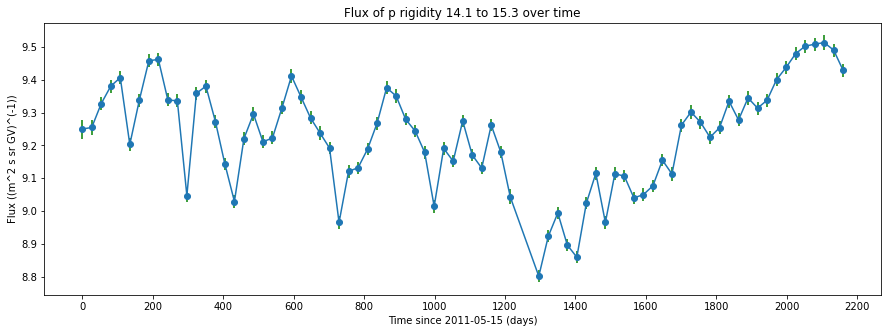

In [2]:
he_files = glob("ams_data/alphas/HE*")
p_files = glob("ams_data/protons/p*")

#determines which rigidity range based on file number.
xml_file = p_files[10] #xml file path

root = ET.parse(xml_file).getroot() #parses the xml and returns the root element
header = root.find('HEADER') #info in header (metadata)
all_data = root.findall('DATA') #all of the data



mins = [data.find("time_min").text for data in all_data] #all of the start times of measurements
x = x_from_dates(mins, dt)
fluxes = [float(data.find("flux").text) for data in all_data] #fluxes for each of the measurements
min_rigid = root.find('DATA/rigidity_min').text
max_rigid = root.find('DATA/rigidity_max').text
particle = header.find('PARTICLE').text

error = {'high': 'flux_statistical_error_high', 'low': 'flux_statistical_error_low'}
sys_error = {'high': 'flux_systematical_error_high', 'low': 'flux_systematical_error_low'}
errors_high = [float(data.find(error['high']).text) for data in all_data]
errors_low = [float(data.find(error['low']).text) for data in all_data]
#errors_high = [float(data.find(sys_error['high']).text) for data in all_data]
#errors_low = [float(data.find(sys_error['low']).text) for data in all_data]

plt.figure(figsize = (15,5))

print(errors_low)
plt.errorbar(x, fluxes, yerr=[np.array(errors_low), np.array(errors_low)], fmt='o-', ecolor='g', capthick=8)
#plt.plot(x, fluxes, '.-')#, x, run_avg(fluxes, 4, 0), '.-')

plt.title(f"Flux of {particle} rigidity {min_rigid} to {max_rigid} over time")
plt.xlabel(f"Time since {mins[0].split('T')[0]} (days)")
plt.xticks(range(0,x[-1]+ 100, 200))
plt.ylabel(f"Flux ({header.find('UNITS/flux').text})")
plt.show()

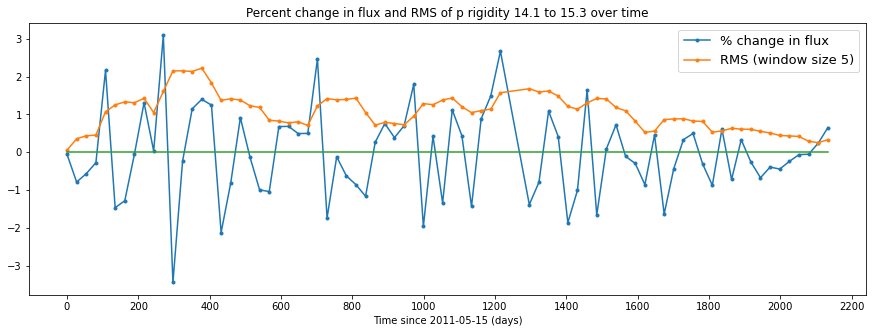

In [3]:
window_size = 5

plt.figure(figsize = (15,5))
new_x = x[:-1]

#list of all delta fluxes
delta_flux = [100*(fluxes[i] - fluxes[i+1])/fluxes[i] for i in range(len(fluxes) -1)]
#plt.errorbar(new_x, delta_flux, yerr=None, fmt='o-', ecolor='g', capthick=8)

pl = plt.plot(new_x, delta_flux, '.-', new_x, run_avg(delta_flux, window_size, 0), '.-', new_x, [0]*len(new_x))
#new_x, [0]*len(new_x) is just the green line in the middle

plt.legend(pl, ['% change in flux', f'RMS (window size {window_size})'], prop={'size': 13})
plt.title(f"Percent change in flux and RMS of {particle} rigidity {min_rigid} to {max_rigid} over time")
plt.xlabel(f"Time since {mins[0].split('T')[0]} (days)")
plt.xticks(range(0,x[-1]+ 100, 200))
plt.ylabel(f"")

plt.show()

In [4]:
#Accessing the csv file
csv = 'ams_data/tables-sm-all.csv'
with open(csv) as f:
    names = f.readline().rstrip().split(',')[0:10]
csv_data = np.genfromtxt(csv, skip_header = 1, delimiter = ',', filling_values = None, usecols = range(11))
bartels, R1, R2, p, p_stat, p_time = csv_data.T[0:6]
#sets the lists to the first six columns

p_syst, He, He_time, He_stat, He_syst = csv_data.T[6:11]
#sets the lists to the first fifteen columns

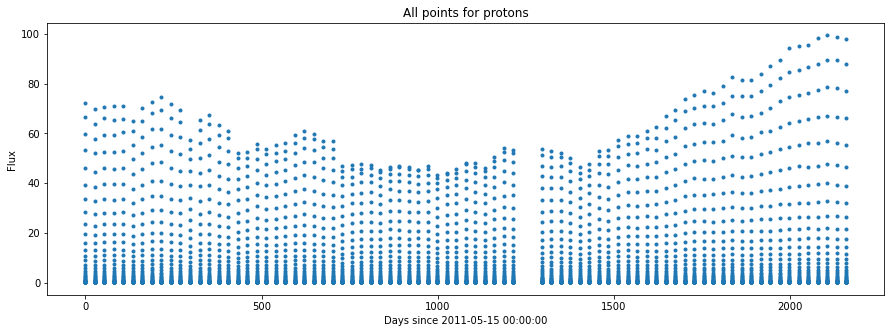

In [5]:
plt.figure(figsize = (15,5))
csv_x = x_from_dates(bartels, bartels_to_date)

plt.plot(csv_x, He, '.')
plt.title(f"All points for protons")
plt.xlabel(f"Days since {bartels_to_date(bartels[0])}")
plt.ylabel(f"Flux")
plt.show()

# New plots by Alex begin here
These following plots attempt to model the flux to rigidity/energy spectrum. A somewhat fitting model is a two term sum of a high energy roll off and low energy roll off power laws. Using this model a fited curve was gnenerated for all flux to rigidity specturms for each bartel rotation. THe coefficients were all recorded and then ploted over bartels. By doing so, the coefficent that determined the falloff threshold for both high energy and low energy both showed that they followed the solar cycle's rise and fall.

After that, the plots begin to compare AMS flux data with ACIS from Chandra average rejected particle tracks per frame binned data to each other. A generally strong correlation was observed for the first 10 rigidity bins (1.0 GV - 3.3 GV) from AMS to the Chandra data. The Root means square error of the AMS to ACIS data was also calculated for each AMS proton rigidity bin. A global minimum RMS value can be observed at around the 1.82-2.15 GV rigidity bin meaning the fitted linear model of AMS to ACIS at that energy range varies very little. 

Some genreal things to keep in mind:
Whenever a call for two lists or arrays is made, make sure they are of same length or a value error will occur when a attempting to plot.

the "barts" array is a list of bartels that have ams data that have data as in the above plot, it shows two bartel rotations without any ams flux data.

There are 45 total rigidity bins the bin ranges are availble in the sm-all.csv file. 

Some of my own variable naming convention:
1. Most variables will be the first one or two sylybles of the full word, for example, coefficient is reduced to coeff.
2. Many lists are often filtered or compiled in some way. These modified lists/arrays are denoted with a single letter in front with the normal name after. For example, there is a function to cut x/y data from a cutoff point for before and after. the resulting lists are all blist or alist where a stands for after and b for before. 
3. The uses of plural versus singluar words as variable names are very deliberate.
4. Anything that breaks these rules are often varialbes sudgested or used as examples from the resources I orginally used to learn the part of code. 

Email me at alex.yu0753@gmail.com or ayu@oberlin.edu if there are any questions.

This is one of the two toggleable variable statments that determine what part of AMS data you are observing, Protons or Alpha particles. The second one is under the next large block of text farther down

In [6]:
#Decide what AMS particle data you want to see from here on out right now
#'alpha' or 'proton'
part = 'proton'


The following function finds total flux for a potentially wider range of rigidity ranges

This function takes in two numbers corresponding to their rigidity bins as defined in the cvs file. Then using those, it complies the flux data for all rigidities in those ranges in a bartel into a single flux and returns the list of fluxes in the order of bartels as well asthe lowest rigidity and the highest rigidity

uncertantiy from multiple sources is calculated by taking the sum of squares of all uncertanties and square rooting them.

0-44 rigidity ranges 

0 = 1.0~ 1.16

10 = 2.79~ 3.29

20 = 7.76~ 8.48

30 = 18.0~ 19.5

44 = 56.1~ 60.3

In [363]:
def create_pflux_data(rigmin, rigmax):
    rig1 = R1[rigmin]
    rig2 = R2[rigmax]

    index = R1 == R1[rigmin]

    sumfluxes = p[index]
    err1 = p_stat[index]
    err2 = p_time[index]
    err3 = p_syst[index]
    for i in range(rigmin + 1, rigmax):
        index = R1 == R1[i]
        indexed_fluxes = p[index]
        indexed_err1 = p_stat[index]
        indexed_err2 = p_time[index]
        indexed_err3 = p_syst[index]
        sumfluxes = sumfluxes + indexed_fluxes
        err1 = err1 + indexed_err1
        err2 = err2 + indexed_err2
        err3 = err3 + indexed_err3
    sumerr=[err1, err2, err3]
    return(rig1, rig2, sumfluxes, sumerr)

#When dealing with Alpha particles, keep in mind the minimum Rigidity is 1.92 or rigmin = 5
def create_heflux_data(rigmin, rigmax):
    rig1 = R1[rigmin]
    rig2 = R2[rigmax]

    index = R1 == R1[rigmin]

    sumfluxes = p[index]
    err1 = He_stat[index]
    err2 = He_time[index]
    err3 = He_syst[index]
    for i in range(rigmin + 1, rigmax):
        index = R1 == R1[i]
        indexed_fluxes = He[index]
        indexed_err1 = He_stat[index]
        indexed_err2 = He_time[index]
        indexed_err3 = He_syst[index]
        sumfluxes = sumfluxes + indexed_fluxes
        err1 = err1 + indexed_err1
        err2 = err2 + indexed_err2
        err3 = err3 + indexed_err3
    sumerr=[err1, err2, err3]
    return(rig1, rig2, sumfluxes, sumerr)

#'part' stands for particle because particle is used in brian's energy from rigidity function.
#This one grabs all rigidity and flux data for a specific bartel rotation. 
def grab_data_from_csv(part, bartel):
    fluxes = []
    energies = []
    rigids = []
    errs = []
    #'alpha' or 'proton' distinction
    index1 = (bartels == bartel)
    if part=='alpha':
        index2 = R1[index1]>=1.92
        fluxes = He[index1][index2]
        errs = [He_stat[index1][index2], He_time[index1][index2], He_syst[index1][index2]]
    elif part=='proton':
        index2 = R1[index1]>=1.00
        fluxes = p[index1]
        errs = [p_stat[index1][index2], p_time[index1][index2], p_syst[index1][index2]]

    #get energy from rigidity by using the function defined above
    energies = (rigidity_to_energy((R1[index1][index2]+R2[index1][index2])/2, r = None, particle=part))
    rigids = (R1[index1][index2]+R2[index1][index2])/2
    
    return(fluxes, energies, rigids, errs)

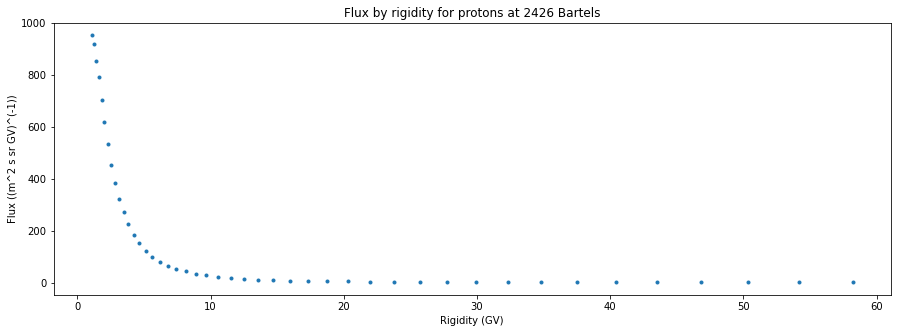

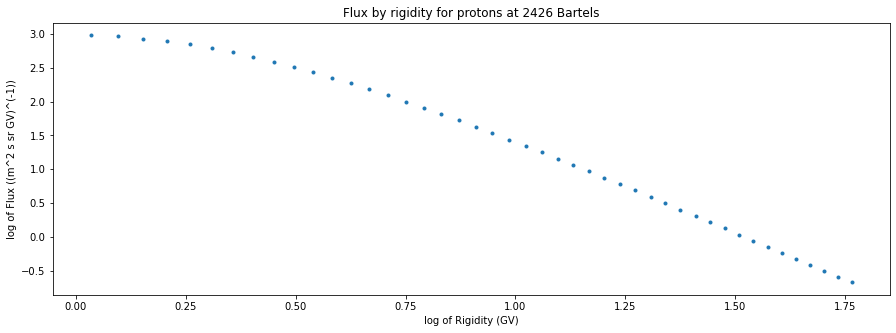

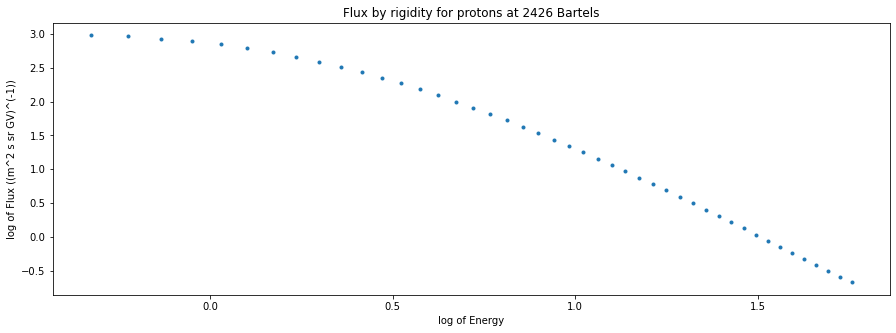

In [364]:
#This is the first test to check if I could make use of the data
#Basic plot of rigidity to flux spectrum for a single bartel
#This was motivated by a meeting where Mark Bautz said the first thing that could potentially be useful 
#was to get a regidity-flux or energy-flux spectrum.

#Change the bartel to any bartel observed by AMS
bartel = 2426
y, x1, x2, dy = grab_data_from_csv(part, bartel)

#y is flux data
#x1 is energy
#x2 is rigidities
#dy is flux uncertanty

#simple plots of a single bartel slice of the data from the csv file
plt.figure(figsize = (15,5))
plt.plot(x2, y, '.', label='Flux by Energy for Protons at {bartel} Bartels')
plt.title(f"Flux by rigidity for {part}s at {bartel} Bartels")
plt.ylabel(f"Flux ({header.find('UNITS/flux').text})")
plt.xlabel(f"Rigidity ({header.find('UNITS/rigidity').text})")
plt.show()

plt.figure(figsize = (15,5))
plt.plot(np.log10(x2), np.log10(y), '.', label='Flux by Energy for Protons at {bartel} Bartels')
plt.title(f"Flux by rigidity for {part}s at {bartel} Bartels")
plt.ylabel(f"log of Flux ({header.find('UNITS/flux').text})")
plt.xlabel(f"log of Rigidity ({header.find('UNITS/rigidity').text})")
plt.show()

plt.figure(figsize = (15,5))
plt.plot(np.log10(x1), np.log10(y), '.', label='Flux by Energy for Protons at {bartel} Bartels')
plt.title(f"Flux by rigidity for {part}s at {bartel} Bartels")
plt.ylabel(f"log of Flux ({header.find('UNITS/flux').text})")
plt.xlabel(f"log of Energy")
plt.show()

slope: -1.933557    intercept: 3.044166
R-squared: 0.960286


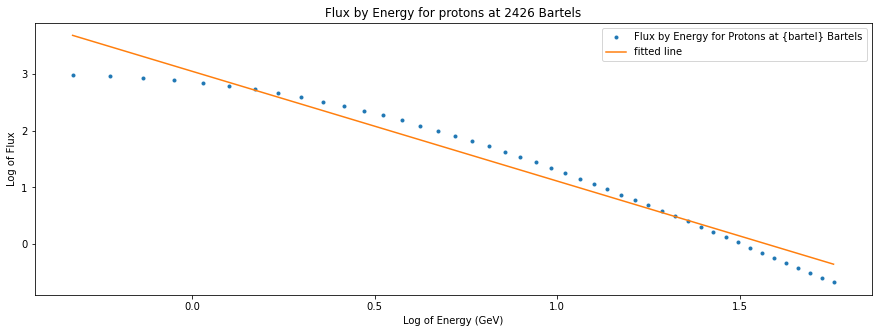

In [365]:
#Now we know that each bartel's rigidity to flux spectrum can be plotted
#I can try to come up with a equation to model the shape of the curve
#check if the flux rigidity spectrums can be modeled with a power law
from sklearn.linear_model import LinearRegression
from scipy import stats

#Change the bartel to any bartel observed by AMS
bartel = 2426
y, x1, x2, dy = grab_data_from_csv(part, bartel)
#y is flux data
#x1 is energy
#x2 is rigidities
#dy is flux uncertanty

ys = np.array(y, dtype=np.float64)
xs = np.array(x1, dtype=np.float64)

logY = np.log10(ys)
logX = np.log10(xs)

slope, intercept, r_value, p_value, std_err = stats.linregress(logX, logY)

print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)

plt.figure(figsize = (15,5))

scale = "log"

#plt.plot (fluxByBartels, energyByRigidity, '.-')
plt.plot(logX, logY, '.', label='Flux by Energy for Protons at {bartel} Bartels')
plt.plot(logX, intercept + slope*logX, label='fitted line')
plt.legend()
plt.title(f"Flux by Energy for {part}s at {bartel} Bartels")
plt.ylabel(f"Log of Flux")
plt.xlabel(f"Log of Energy (GeV)")
#plt.yscale(scale)
#plt.xscale(scale)
plt.show()

#The first guess was a power law so therefore a linear fit to the log-log of the data
#This shows that it is not a power law as it rolls off at both high and low energy

45 45
[ 2.87148568 -0.59584774 -1.1904418   0.21433964]


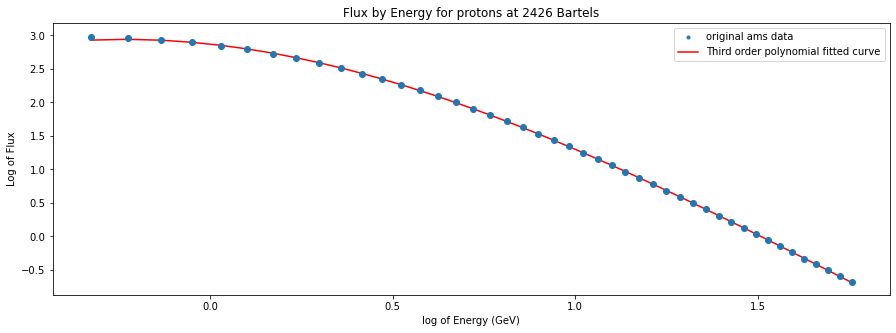

In [366]:
#In order to fit more complicated equations, the scipy.optimize is brought in and used
#this is a simple example with a third order polynomial to the log log of the data check if scipy.optimize works well

from mpl_toolkits import mplot3d
import scipy.optimize as opt
np.seterr(divide='ignore', invalid='ignore')

#Change the bartel to any bartel observed by AMS
bartel = 2426
y, x1, x2, dy = grab_data_from_csv(part, bartel)
#y is flux data
#x1 is energy
#x2 is rigidities
#dy is flux uncertanty
print(len(y),len(x1))

xdata = np.array(x1, dtype=np.float64)
ydata = np.array(y, dtype=np.float64)
x0 = np.array([1.0, 0, 1.0, 1.0])
#so what is happening is that dy alone is a list of all 3 error sources as 3 lists
#so you can choose which sources of err to keep in or out by removing its's square
sigma = np.array((dy[0]**2+dy[1]**2+dy[2]**2)**0.5, dtype=np.float64)

#the transformation to log log here instead of on the scale is because it is easier to fit at this step instead of the base data
logX = np.log10(xdata)
logY = np.log10(ydata)

#reletive errors
sigmaE = sigma / ydata
sigma10 = (1/np.log(10))*sigma/ydata

def func(x, a, b, c, d):
    return a + b*x + c*x**2 + d*x**3

#data for a few bartel rotations are completely missing
try:
    coeff, matrix = opt.curve_fit(func, logX, logY, x0, sigma10)
except RuntimeError:
    print("RuntimeError, no optimization found, these are the results stored in memory")
    pass

print(coeff)

a = coeff[0]
b = coeff[1]
c = coeff[2]
d = coeff[3]

plt.figure(figsize = (15,5))

#plot original data
plt.plot(logX, logY, '.', label='original ams data')
plt.errorbar(logX, logY, yerr=[sigma10, sigma10], fmt='o', ecolor='g', capthick=8)

#plot fitted curve
plt.plot(logX, a + b*logX + c*logX**2 + d*logX**3, 'r', label='Third order polynomial fitted curve')

plt.title(f"Flux by Energy for {part}s at {bartel} Bartels")
plt.ylabel(f"Log of Flux") 
plt.xlabel(f"log of Energy (GeV)")
plt.legend()
plt.show()

#high order polynomials can fit curves very well, but their coefficients do not tell us anything about
#the underlying principles on why these curves are the way they are or how they vary across different
#bartel rotaions

In [367]:
#Re manipulate the csv data to try and fit with a different function
#Fsum of two roll offs?

#Change the bartel to any bartel observed by AMS
bartel = 2426
y, x1, x2, dy = grab_data_from_csv(part, bartel)
#y is flux data
#x1 is energy
#x2 is rigidities
#dy is flux uncertanty
print(len(y),len(x1))

xdata = np.array(x1, dtype=np.float64)
ydata = np.array(y, dtype=np.float64)
#so what is happening is that dy alone is a list of all 3 error sources as 3 lists
#so you can choose which sources of err to keep in or out by removing its's square
sigma = np.array((dy[0]**2+dy[1]**2+dy[2]**2)**0.5, dtype=np.float64)

#the transformation to log log here instead of on the scale is because it is easier to fit at this step instead of the base data
logX = np.log10(xdata)
logY = np.log10(ydata)

#reletive errors
ydataP = np.log10(ydata + dy)
ydataM = np.log10(ydata - dy)
sigma10 = (1/np.log(10))*sigma/ydata
sigmaE = sigma/ydata

#print(sigma, sigma10, sigmaE)

45 45


The SUM of roll off models one for high energy and the other for low energy in ln and log10

In [368]:
#Makes use of the opt.curve_fit function
#initial guesses of coefficient values
 
x0 = np.array([1.0,-2.0,-10.0,1.0,1.0,1.0])

#Guessed function is a sum of a high energy roll off power law and a low energy power law
def func(x, a, b, c, d, f, g):
    return np.log(np.exp(a + b*np.log(x) -c/x) + np.exp(d + f*np.log(x) -x/g))

coeff, matrix = opt.curve_fit(func, xdata, np.log(ydata), x0, sigmaE)
print(coeff)

a = coeff[0]
b = coeff[1]
c = coeff[2]
d = coeff[3]
f = coeff[4]
g = coeff[5]

[ 9.99126434 -2.83672862  4.63883773  8.71853112  0.90658698  0.40533487]


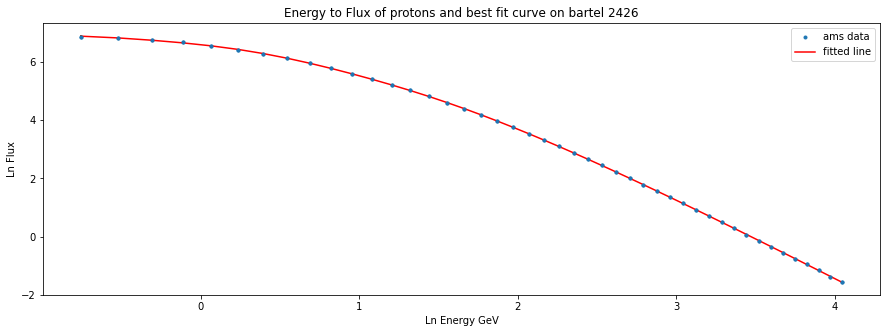

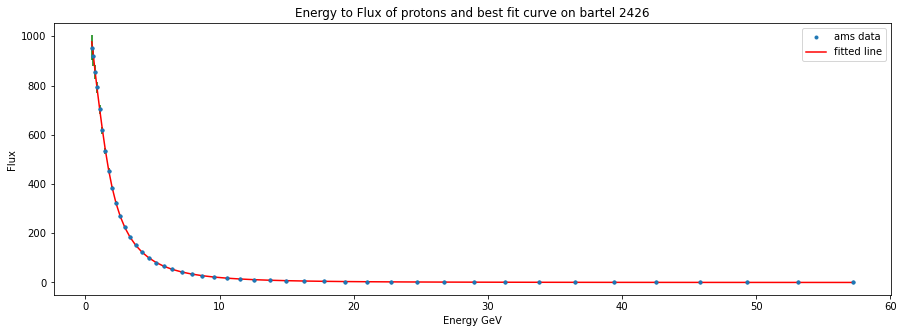

In [369]:
#Plotting in natural log scale
plt.figure(figsize = (15,5))
plt.plot(np.log(xdata), np.log(ydata), '.', label='ams data')
plt.errorbar(np.log(xdata), np.log(ydata), yerr=[sigmaE, sigmaE], fmt='.', ecolor='g', capthick=8)
plt.plot(np.log(xdata), np.log(np.exp(-c/xdata + a + b*np.log(xdata)) + np.exp(-xdata/g + d + f*np.log(xdata))), 'r', label='fitted line')
plt.title(f"Energy to Flux of {part}s and best fit curve on bartel {bartel}")
plt.xlabel(f"Ln Energy GeV")
plt.ylabel(f"Ln Flux")
plt.legend()
plt.show()

#Plotting in normal
plt.figure(figsize = (15,5))
plt.plot(xdata, ydata, '.', label='ams data')
plt.errorbar(xdata, ydata, yerr=[sigma, sigma], fmt='.', ecolor='g', capthick=8)
plt.plot(xdata, (np.exp(-c/xdata + a + b*np.log(xdata)) + np.exp(-xdata/g + d + f*np.log(xdata))), 'r', label='fitted line')
plt.title(f"Energy to Flux of {part}s and best fit curve on bartel {bartel}")
plt.xlabel(f"Energy GeV")
plt.ylabel(f"Flux")
plt.legend()
plt.show()

#These plots show that the model proposed is an "ok" model

[ 9.99126357 -2.83672842  4.63883493  8.71853564  0.90659029  0.40533403]


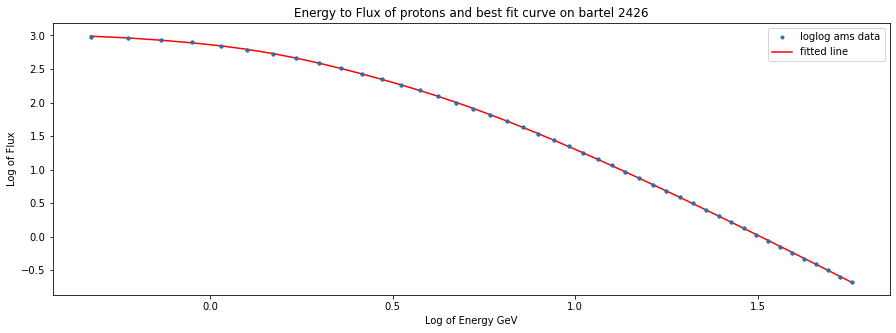

In [370]:
#Same plot but on a log10 fit
#Guessed function
def func(x, a, b, c, d, f, g):
    return np.log10(np.exp(a + b*np.log(x) -c/x) + np.exp(d + f*np.log(x) -x/g))
coeff, matrix = opt.curve_fit(func, xdata, np.log10(ydata), x0, sigma10)
print(coeff)

a = coeff[0]
b = coeff[1]
c = coeff[2]
d = coeff[3]
f = coeff[4]
g = coeff[5]

plt.figure(figsize = (15,5))
plt.plot(np.log10(xdata), np.log10(ydata), '.', label='loglog ams data')
plt.errorbar(np.log10(xdata), np.log10(ydata), yerr=[sigma10, sigma10], fmt='.', ecolor='g', capthick=8)
plt.plot(np.log10(xdata), np.log10(np.exp(-c/xdata + a + b*np.log(xdata)) + np.exp(-xdata/g + d + f*np.log(xdata))), 'r', label='fitted line')
plt.title(f"Energy to Flux of {part}s and best fit curve on bartel {bartel}")
plt.xlabel(f"Log of Energy GeV")
plt.ylabel(f"Log of Flux")
plt.legend()
plt.show()

#We can determine that a sum of two power laws does fit the curve mapped out by the data better but it is still not perfect
#especially around the lower energy side where the distance between the curve and data point is visible

In [371]:
#By running the curve fit through all bartels, we can see the variation of the coefficients to see
#if they tell us anything interesting

#arrays to store coefficients
a = []
b = []
c = []
d = []
f = []
g = []
barts = []

def func(x, a, b, c, d, f, g):
    return np.log10(np.exp(a + b*np.log(x) - c/x) + np.exp(d + f*np.log(x) - x/g))
print("log10(np.exp(a + b*ln(x) - c/x) + np.exp(d + f*np.ln(x) - x/g))")

for i in range(2426,2507):
    index = (bartels==i)
    energy = rigidity_to_energy(((R1[index] + R2[index])/2), r = None, particle='proton')
    flux = p[index]
    stat = p_stat[index]
    xdata = np.array(energy, dtype=np.float64)
    ydata = np.array(flux, dtype=np.float64)
    sigma = np.array(stat, dtype=np.float64)
    
    sigma10 = (1/np.log(10))*sigma/ydata
    sigmaE = sigma/ydata
    
    try:
        coeff, matrix = opt.curve_fit(func, xdata, np.log10(ydata), x0, sigma10)
        #print(f"Bartel {i}: ", coeff)
        barts.append(i)
        a.append(coeff[0])
        b.append(coeff[1])
        c.append(coeff[2])
        d.append(coeff[3])
        f.append(coeff[4])
        g.append(coeff[5])
    #This is to ignore the empty bartel rotations.
    except ValueError:
        pass
    except TypeError:
        pass
    

log10(np.exp(a + b*ln(x) - c/x) + np.exp(d + f*np.ln(x) - x/g))


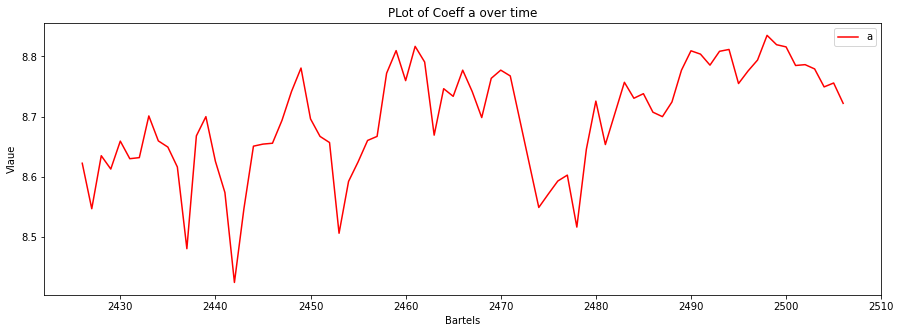

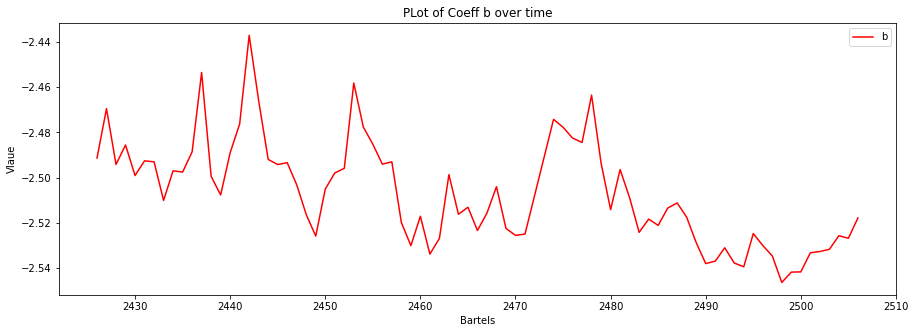

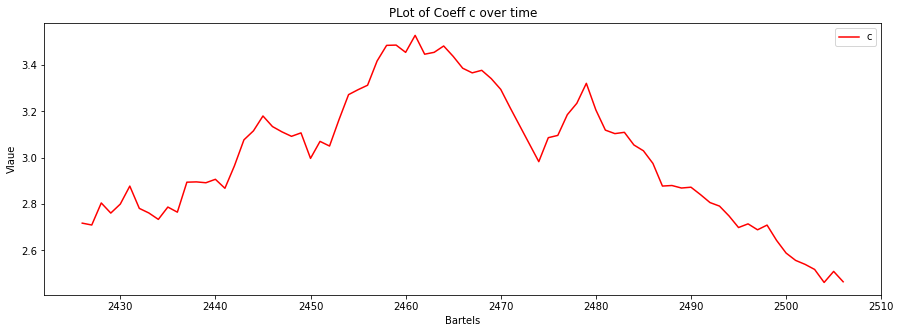

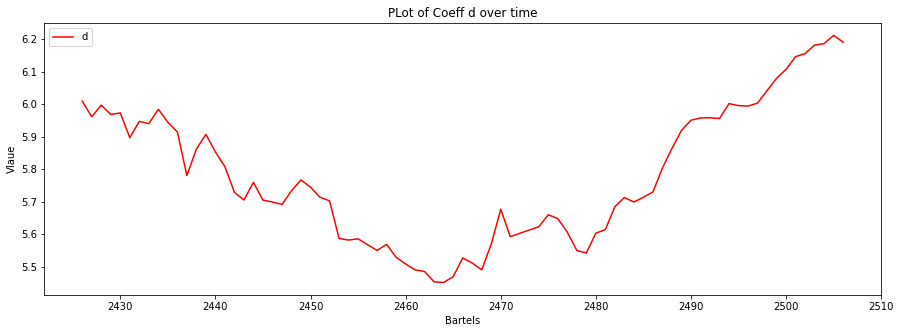

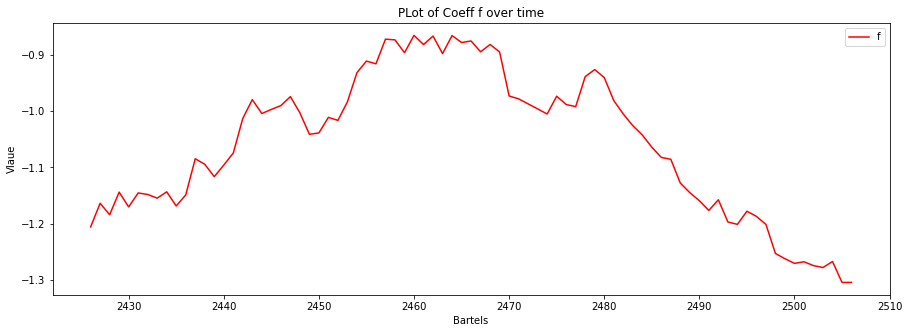

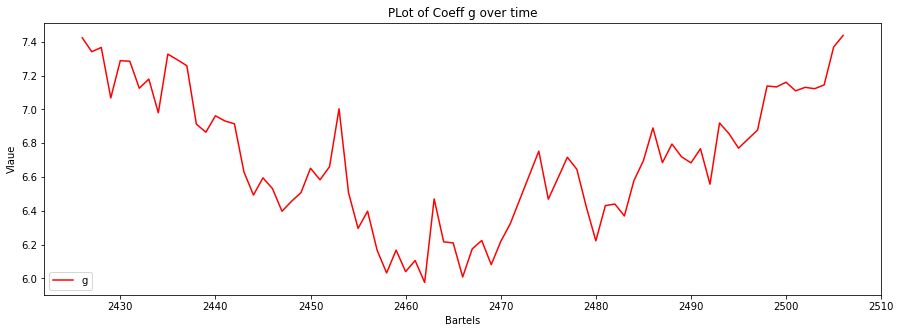

In [372]:
# plot of A over time
#strictly speaking, a here is actually ln(a)
plt.show()
plt.figure(figsize = (15,5))
plt.plot(barts, a, 'r', label='a')
plt.title(f"PLot of Coeff a over time")
plt.xlabel(f"Bartels")
plt.ylabel(f"Vlaue")
plt.legend()
plt.show()

# plot of B over time
plt.show()
plt.figure(figsize = (15,5))
plt.plot(barts, b, 'r', label='b')
plt.title(f"PLot of Coeff b over time")
plt.xlabel(f"Bartels")
plt.ylabel(f"Vlaue")
plt.legend()
plt.show()

# plot of C over time
# C describes the point when low energy begins to influence the curve more
plt.show()
plt.figure(figsize = (15,5))
plt.plot(barts, c, 'r', label='c')
plt.title(f"PLot of Coeff c over time")
plt.xlabel(f"Bartels")
plt.ylabel(f"Vlaue")
plt.legend()
plt.show()

# plot of D over time
plt.show()
plt.figure(figsize = (15,5))
plt.plot(barts, d, 'r', label='d')
plt.title(f"PLot of Coeff d over time")
plt.xlabel(f"Bartels")
plt.ylabel(f"Vlaue")
plt.legend()
plt.show()

# plot of F over time
plt.show()
plt.figure(figsize = (15,5))
plt.plot(barts, f, 'r', label='f')
plt.title(f"PLot of Coeff f over time")
plt.xlabel(f"Bartels")
plt.ylabel(f"Vlaue")
plt.legend()
plt.show()

# plot of G over time
# G describes the point when high energy begins to influence the curve more
plt.show()
plt.figure(figsize = (15,5))
plt.plot(barts, g, 'r', label='g')
plt.title(f"PLot of Coeff g over time")
plt.xlabel(f"Bartels")
plt.ylabel(f"Vlaue")
plt.legend()
plt.show()

# New new era


This marks the introduction and access of the ACIS bkg file
This file details the average counts of rejected events per frame for a given time period on the chandra satellite. These time periods are far shorter than 27 days which is the period that the AMS on the international space station counts.  

The primary purpouse was to compare AMS to ACIS data for some insight on how orbit affects the ammount and energy of particles detected by both. It should be noted that both satellites are in vastly different orbits where the ISS(AMS) is in a lower orbit than Chandra(ACIS). 

By comparing AMS flux data at different rigidities/energy bins to ACIS' average average counts per frame, an somewhat obvious conclusion can be made that for lower energy ranges. AMS flux data can be somewhat predicted using ACIS data as they seem to correlate very well. 



In [373]:
#Decide what AMS particle data you want to see from here on out right now
#'alpha' or 'proton'
part = 'proton'

False


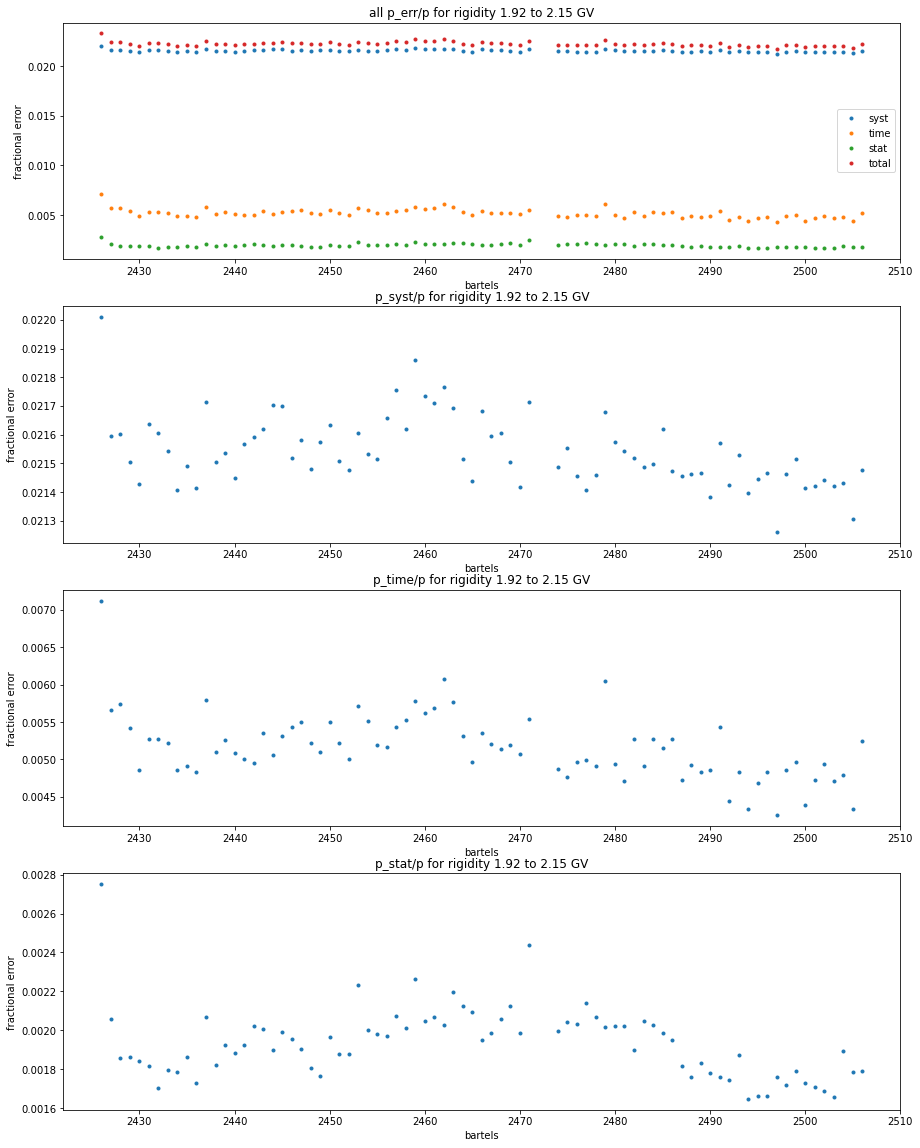

In [389]:
#Here are some plots to help visualize the change in various sources of error over time for specific rigidity bins
#All ams error bars now correspond to the red dots plotted below for their respective data sets.
#when summing flux arrays, the total uncertanties are summed as well.

#Change r1 to whatever rigidity bin you want
r1=5
index = R1 == R1[r1]
if part =='alpha':
    name = 'He'
    r1p_syst = He_syst[index]
    r1p_time = He_time[index]
    r1p_stat = He_stat[index]
    r1p = He[index]
    print(index[10])
    r1, r2, fluxes, fluxerr = create_heflux_data(r1, r1)
elif part =='proton':
    name = 'p'
    r1p_syst = p_syst[index]
    r1p_time = p_time[index]
    r1p_stat = p_stat[index]
    r1p = p[index]
    print(index[10])
    r1, r2, fluxes, fluxerr = create_pflux_data(r1, r1)

plt.figure(figsize = (15,20))
plt.subplot(411)
plt.plot(barts, r1p_syst/r1p, '.', label='syst')
plt.plot(barts, r1p_time/r1p, '.', label='time')
plt.plot(barts, r1p_stat/r1p, '.', label='stat')
plt.plot(barts, (fluxerr[0]**2+fluxerr[1]**2+fluxerr[2]**2)**0.5/r1p, '.', label='total')
plt.title(f"all {name}_err/{name} for rigidity {r1} to {r2} GV")
plt.legend()
plt.xlabel(f"bartels")
plt.ylabel(f"fractional error")

plt.subplot(412)
plt.plot(barts, r1p_syst/r1p, '.', label='syst')
plt.title(f"{name}_syst/{name} for rigidity {r1} to {r2} GV")
plt.xlabel(f"bartels")
plt.ylabel(f"fractional error")

plt.subplot(413)
plt.plot(barts, r1p_time/r1p, '.')
plt.title(f"{name}_time/{name} for rigidity {r1} to {r2} GV")
plt.xlabel(f"bartels")
plt.ylabel(f"fractional error")

plt.subplot(414)
plt.plot(barts, r1p_stat/r1p, '.')
plt.title(f"{name}_stat/{name} for rigidity {r1} to {r2} GV")
plt.xlabel(f"bartels")
plt.ylabel(f"fractional error")
plt.show()

In [396]:
#functions for the ACIS to AMS data analysis and comparison
#both functions take in a cutoff bartel rotation and the x data(bartels) and y data(acis or ams)
def dat_split_before(cutoff, xs, ys):
    xs = np.array(xs, dtype=np.float64)
    ys = np.array(ys, dtype=np.float64)
    index = xs<=cutoff
    nxs = xs[index]
    nys = ys[index]
    return(nxs, nys)

def dat_split_after(cutoff, xs, ys):
    xs = np.array(xs, dtype=np.float64)
    ys = np.array(ys, dtype=np.float64)
    index = xs>cutoff
    nxs = xs[index]
    nys = ys[index]
    return(nxs, nys)

#reorder flux data from least to greatest for a linear regression
def reorder(ams_data, acis_data, dams_data, dacis_data):
    sflux = np.sort(ams_data)
    indexs = np.argsort(ams_data)
    sdata = []
    sfluxerr = []
    sdataerr = []
    for i in range(len(acis_data)):
        sdata.append(acis_data[indexs[i]]) 
        sfluxerr.append(dams_data[indexs[i]]) 
        sdataerr.append(dacis_data[indexs[i]]) 
    return(sflux, sdata, sfluxerr, sdataerr)

#Simple function to calculate fractional RMS from a linear fit
#The propegation of error is currently incorrect, but as it is the end of my internship, that difficult task falls on 
#whoever works on this next and is interested in seeing the RMS variation based on uncertanties in slope and y intercept when
#linear fitting ams flux to acis counts per frame.
def get_fRMS(x, y, dx, dy, m, b):
    residuals = []
    dresiduals = []
    for i in range(len(x)-1):
        residuals.append(((y[i]-(m*x[i]+b))/(y[i]))**2 )
        #RMS uncertantly is sum of suquares of partial derivative times the part
        #Partial derivative of residual squared in repsect of y is (-2*(b-m*x)*(b-m*x+y)/(y**3))
        #Partial derivative of residual squared in repsect of x is (-2*m*(b-m*x+y))/(y**2)
        #dr**2 = (dr/dx * dx)**2 + (dr/dy * dy)**2
        #The RMS error calculation is currently incorrect and until I learn how to find error in m and b
        #it will remain broken so do not use the second return for anything
        dresiduals.append((((-2*(b-m*x[i])*(b-m*x[i]+y[i])/(y[i]**3))*dy[i])**2 + 
                           (((-2*m*(b-m*x[i]+y[i]))/(y[i]**2))*dx[i])**2)**0.5)
    #khan academy told me to subtract 1 so I do so.
    rms = (sum(residuals)/(len(residuals)-1))**0.5
    #Uncertanty of a sum is the sum of the uncertanties
    drms = (sum(dresiduals)/(len(dresiduals)-1))**0.5
    return rms, drms

#Simple function to calculate absolute RMS from a linear fit
def get_RMS(x, y, dx, dy, m, b):
    residuals = []
    dresiduals = []
    for i in range(len(x)-1):
        residuals.append((y[i]-(m*x[i]+b))**2 )
        #RMS uncertantly is sum of suquares of partial derivative times the part
        #Partial derivative of residual squared in repsect of y is 2(b-mx+y)
        #Partial derivative of residual squared in repsect of x is -2m(b-mx+y)
        #dr**2 = (dr/dx * dx)**2 + (dr/dy * dy)**2
        #The RMS error calculation is currently incorrect and until I learn how to find error in m and b
        #it will remain broken so do not use the second return for anything
        dresiduals.append(((2*(b-m*x[i]+y[i])*dy[i])**2 + ((-2*m*(b-m*x[i]+y[i]))*dx[i])**2)**2) # = risidual**2
    #khan academy told me to subtract 1 so I do so.
    rms = ((sum(residuals)**0.5)/(len(residuals)-1))
    #Uncertanty of a sum is the sum of the uncertanties
    drms = (sum(dresiduals)/(len(dresiduals)-1))**0.5
    return rms, drms

In [397]:
#access the acis bkg file
#the file has been modified to conform to a csv file format
acis = 'acis_data/acis.s3.bkg.txt'
with open(acis) as file:
    names = file.readline().rstrip().split(',')[0:11]
acis_data = np.genfromtxt(acis, skip_header = 1, delimiter = ',', filling_values = None, usecols = range(3))

Time, S3, S3err = acis_data.T[0:3]

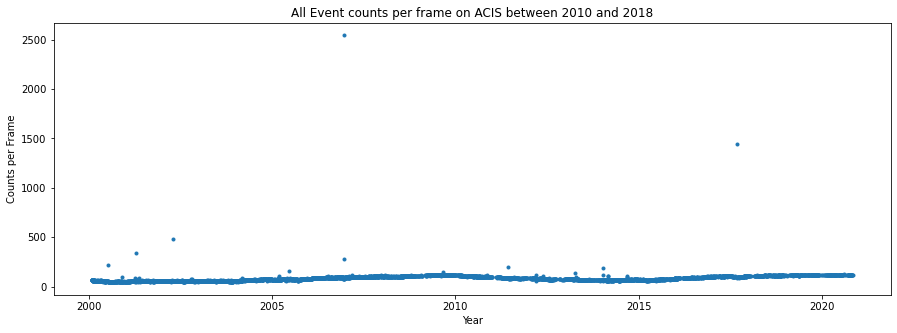

In [398]:
#plot all data in the acis file
plt.figure(figsize = (15,5))
plt.plot(Time, S3, '.')
plt.title(f"All Event counts per frame on ACIS between 2010 and 2018")
plt.xlabel(f"Year")
plt.ylabel(f"Counts per Frame")
plt.show()

#Because each point is a average counts per frame for a given time frame. It means for the outliers,
#there were a non trivial number of frames with exceedingly high counts of regected events meaning one of two possibilities:
#there was a single frame with a much much larger number of counts or multiple frames had around the displayed number of counts.

In [399]:
#Some Filters to narrow the window to the same time frame as ams
#print(Time)
#bartel 2426 is about 2011.37
index = Time>=2011.3700
#Copy lists from source for manipulation in case the original data needs to be used later
#This means that Time, S3, and S3err are not changed and the previous plot can be rerun without a problem
nTime = Time[index]
nS3 = S3[index]
nS3err = S3err[index]
#print(Time)
#bartel 2506 is about 2017.36
index = nTime<=2017.3600
nTime = nTime[index]
nS3 = nS3[index]
nS3err = nS3err[index]

nTime = np.array(nTime)
nS3 = np.array(nS3)
nS3err = np.array(nS3err)

#basic compare-with-past-two-values outlier filtering algorithm
#Please keep in mind this algorithm will not work if the data has sudden plateus where one jump is huge
#in magnitude and remains in that state.

#Higher values for cutoff allow for less strict filtering
#More loops means running the data through the filter more times
cutoff = 15
filterloops = 10
outliers = []

#so this trains however many times specified to remove outliers
for i in range(filterloops):
    for t in range(len(nTime)-1):
        try:
            dow1 = ((nS3[t] - nS3[t-1])**2)**0.5
        except IndexError:
            dow1 = 0
        try:
            dow2 = ((nS3[t] - nS3[t-2])**2)**0.5
        except IndexError:
            dow2 = 0   
        
#            print(dow1, dow2)    
        if ((dow1 > cutoff) and (dow2 >cutoff)):
            outliers.append(nTime[t])
    for o in range(len(outliers)-1):
        out = nTime!=outliers[o]
        nTime = np.array(nTime[out])
        nS3 = np.array(nS3[out])
        nS3err = np.array(nS3err[out])
#    print(outliers)


#nTime, nS3, nS3err are now the three data arrays with outliers removed
print(f"{len(outliers)} outliers were removed")

18 outliers were removed


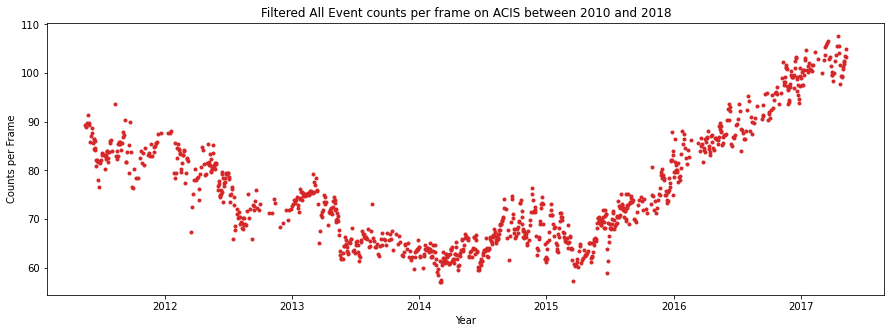

[2000.08   2000.0803 2000.0859 ... 2020.8215 2020.8286 2020.8359]


In [400]:
#plotting the filtered data

plt.figure(figsize = (15,5))
#plt.plot(nTime, nS3, '.', color='tab:red')
plt.errorbar(nTime, nS3, yerr=[nS3err, nS3err], color='tab:red', fmt='.', ecolor='b', capthick=8)
plt.title(f"Filtered All Event counts per frame on ACIS between 2010 and 2018")
plt.xlabel(f"Year")
plt.ylabel(f"Counts per Frame")
plt.show()
print(Time)

In [401]:
#Binning can only happend after preliminary filtering has been completed

#Bin the data into bartel rotations
#Compile each Count per frame into an average within the bin and each group of days into a corresponding bartel
#Bartel 2426 begins 05-15-2011 or day 135 which is 135/365 = 0.36986 so the first lower bound is 2011.36986
#Each bartel is exactly 27 days or 27/3657 years and 27/366 years which makes it difficult to use pandas

#These following variables could and should probably be in the input for the binning function but because it is used multiple 
#times later and do not change, out of lazyness, I kept them here instead of in the parenthesis 
l_bound = 135/365 + 2011
b_length = 27/365
lyb_length = 27/366
u_bound = 103/365 + 2017
starting_bartel = 2426
#This function bins the filtered acis data but taking in a fist and last day in the form of year decimals. The input year decimals 
def acis_binning(lower_bound, upper_bound):
    
    print(lower_bound, upper_bound)

    i = lower_bound
    counter = 0
    lb = []
    ub = []

    #defines all time sections to look at
    while (i <= upper_bound + b_length):
        #print(i, counter + 2426)
        counter = counter + 1
        #step one is to create a list of upper and lower bounds of the bins
        #leap year check
        #because of the leap years, the length of a bartel(exactly 27 days) is not always the same fraction of a year
        if (int(i)/4 == i//4):
            lb.append(i)
            i = i + lyb_length
            ub.append(i)
        else:
            lb.append(i)
            i = i + b_length
            ub.append(i)
    
    bartels_acis = []
    avgs = []
    RMSs = []
    i = 0
    
    for i in range(len(ub)):
        #Using slicing, each bin is created by grouping all data points that are within the above defined time ranges
        #into single data points. It does this by creating two lists of matching size indicating the upper and lower bounds.
        #It could potentially be more efficient if it was just the lower bound + the last upper bound but dealing with the 
        #list indices was easier with two seperate lists
        index1 = (ub[i] > nTime)
        group = nTime[index1]
        data = nS3[index1]
        dataerr = nS3err[index1]
    
        index2 = (lb[i] < group)
        group = group[index2]
        data = data[index2]
        dataerr = dataerr[index2]
        #print(group)
        #Using the newly created list of data points to bin, the average value of them is caluclated and added
        #to the list of newly manipulated data
        avg = sum(data)/len(data)
        RMS = (sum(dataerr**2)/(len(data)-1))**0.5
        
        avgs.append(avg)
        #RMSs is the list of uncertanties caused by statistical error in the acis data. 
        RMSs.append(RMS)
        #this line is under the assumption that every input is at the starting bartel 2426. 
        #This could be modified using datetime to get a bartel from a date but all ams data I worked with were from 2426 to 2506.
        #and this is a function to map binned and averaged acis data to corresponding ams data.
        bartels_acis.append(starting_bartel+i)
        
    return(bartels_acis, avgs, RMSs)


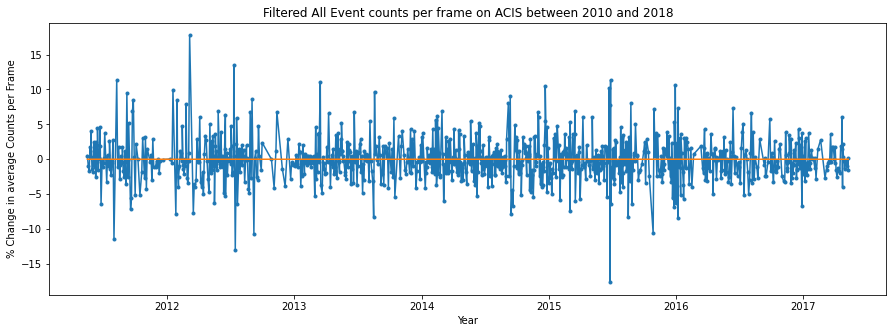

In [402]:
#plotting the percent change over time from the previous data point

plt.figure(figsize = (15,5))
new_x = nTime[:-1]
delta_S3 = [100*(nS3[i] - nS3[i+1])/nS3[i] for i in range(len(nS3) -1)]

pl = plt.plot(new_x, delta_S3, '.-', new_x, [0]*len(new_x))
#new_x, [0]*len(new_x) is just the green line in the middle

plt.title(f"Filtered All Event counts per frame on ACIS between 2010 and 2018")
plt.xlabel(f"Year")
plt.ylabel(f"% Change in average Counts per Frame")
plt.show()

#notice how some sudden spikes correlate to the same drops or rises in the above plot

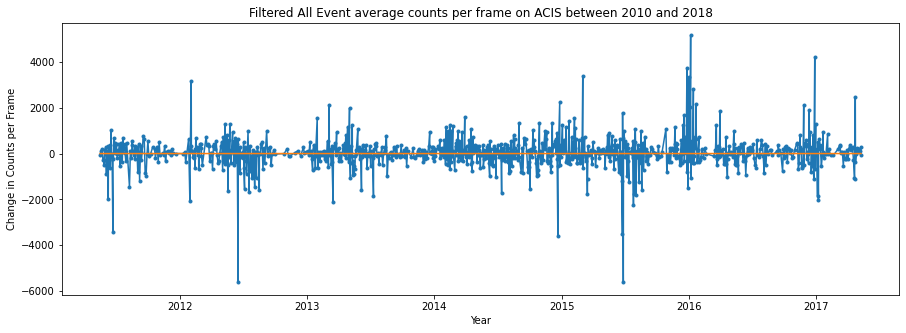

In [403]:
#Plotting slopes... should it mean anything

plt.figure(figsize = (15,5))
new_x = nTime[:-1]
delta_S3 = [(nS3[i+1]-nS3[i])/(nTime[i+1]-nTime[i]) for i in range(len(nS3) -1)]

pl = plt.plot(new_x, delta_S3, '.-', new_x, [0]*len(new_x))
#new_x, [0]*len(new_x) is just the green line in the middle

plt.title(f"Filtered All Event average counts per frame on ACIS between 2010 and 2018")
plt.xlabel(f"Year")
plt.ylabel(f"Change in Counts per Frame")
plt.show()

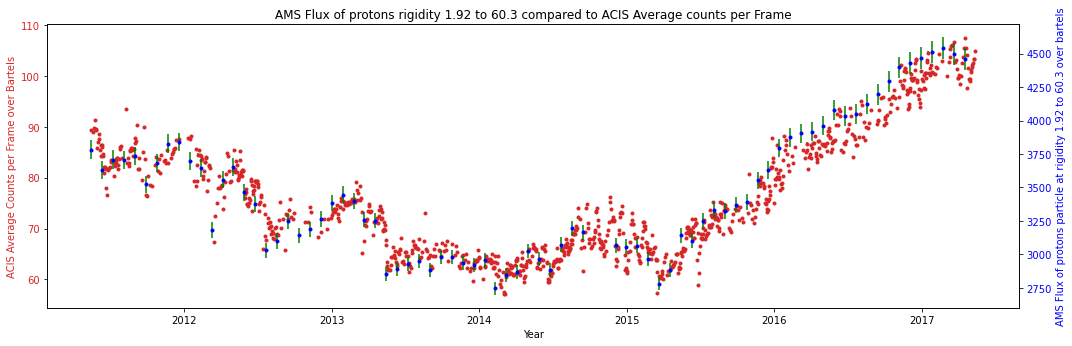

In [384]:
#plotting both ACIS and AMS together
#Find total flux for a potentially wider range of rigidity ranges
#0-44 rigidity ranges
#0 = 1.0~ 1.16
#44 = 56.1~ 60.3
#keep in mind if the particle is alpha, the minimum rlow can be is 5
rlow = 5
rhigh = 44

if part=='alpha':
    r1, r2, fluxes, fluxerr = create_heflux_data(rlow, rhigh)
elif part=='proton':
    r1, r2, fluxes, fluxerr = create_pflux_data(rlow, rhigh)
    


csv_x = x_from_dates(barts, bartels_to_date)
t1 = nTime 
t2 = (csv_x/365)+nTime[0]
data1 = nS3
data2 = fluxes
data1err = nS3err
#fluxerr was returned as a list of 3 arrays of uncertanties. 
data2err = (fluxerr[0]**2+fluxerr[1]**2+fluxerr[2]**2)**0.5

fig, ax1 = plt.subplots(figsize=(15, 5))

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('ACIS Average Counts per Frame over Bartels', color=color)
ax1.errorbar(t1, data1, color=color, yerr=[data1err, data1err], fmt='.', ecolor='g', capthick=8)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'blue'
ax2.set_ylabel(f'AMS Flux of {part}s particle at rigidity {r1} to {r2} over bartels', color=color)  # we already handled the x-label with ax1
#ax2.plot(t2, data2,  '.', color=color)
ax2.errorbar(t2, data2, color=color, yerr=[data2err, data2err], fmt='.', ecolor='g', capthick=8)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"AMS Flux of {part}s rigidity {r1} to {r2} compared to ACIS Average counts per Frame")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

2011.3698630136987 2017.282191780822


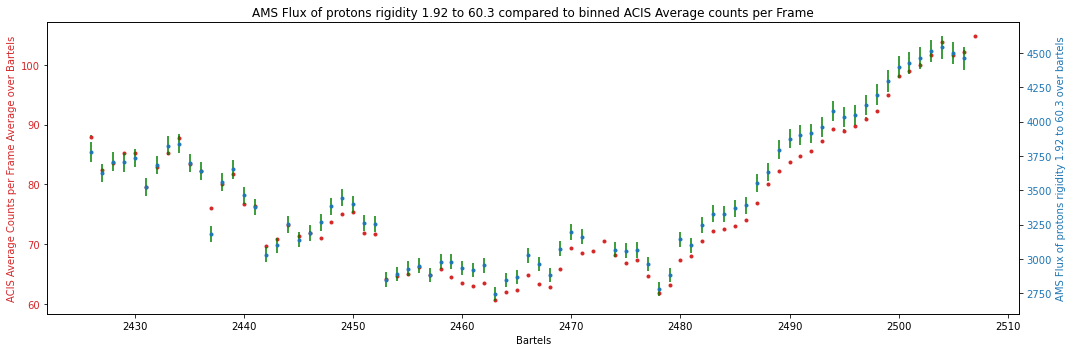

In [404]:
#plotting both ACIS and AMS together
#Find total flux for a potentially wider range of rigidity ranges
#0-44 rigidity ranges
#0 = 1.0~ 1.16
#44 = 56.1~ 60.3


#indicates what ams rigidity bin(s) to look at

rlow = 5
rhigh = 44

if part=='alpha':
    r1, r2, fluxes, fluxerr = create_heflux_data(rlow, rhigh)
elif part=='proton':
    r1, r2, fluxes, fluxerr = create_pflux_data(rlow, rhigh)
    
barts_acis, aacpf, rmss= acis_binning(l_bound, u_bound)

t1 = barts_acis
t2 = barts
data1 = aacpf
data2 = fluxes
data1err = rmss
#fluxerr was returned as a list of 3 arrays of uncertanties. 
data2err = (fluxerr[0]**2+fluxerr[1]**2+fluxerr[2]**2)**0.5

fig, ax1 = plt.subplots(figsize=(15, 5))

color = 'tab:red'
ax1.set_xlabel('Bartels')
ax1.set_ylabel('ACIS Average Counts per Frame Average over Bartels', color=color)
ax1.errorbar(t1, data1, color=color, yerr=[data1err, data1err], fmt='.', ecolor='g', capthick=8)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(f'AMS Flux of {part}s rigidity {r1} to {r2} over bartels', color=color)
ax2.errorbar(t2, data2, color=color, yerr=[data2err, data2err], fmt='.', ecolor='g', capthick=8)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"AMS Flux of {part}s rigidity {r1} to {r2} compared to binned ACIS Average counts per Frame")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#Python plots auto scales the axis such that the global maximum and minimum points of both arrays 
#are at the same hight on the plot.

#To simplify things for the following section, combinations of error will be defined here


In [405]:
allthree = (fluxerr[0]**2+fluxerr[1]**2+fluxerr[2]**2)**0.5

2011.3698630136987 2017.282191780822


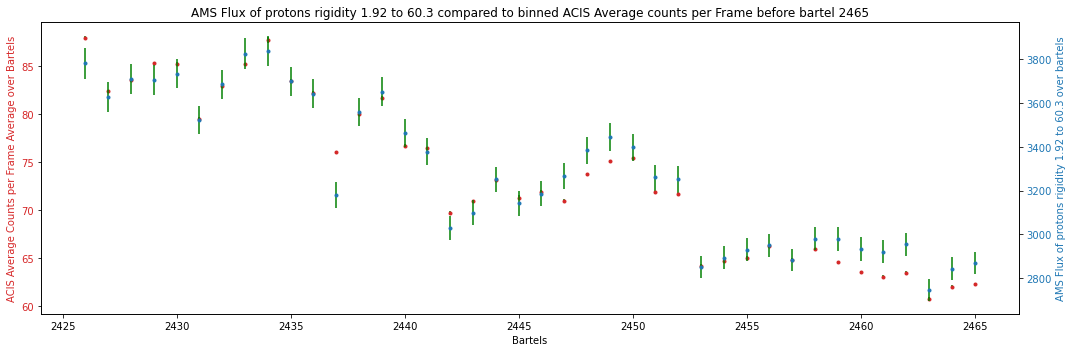

In [407]:
#plotting bartels before rotation 2470 for both ACIS and AMS together
barts_acis, aacpf, rmss = acis_binning(l_bound, u_bound)

cutoff = 2465
#b for before
bbarts, bfluxes = dat_split_before(cutoff, barts, fluxes)
bbarts, bfluxerr = dat_split_before(cutoff, barts, allthree)
bbarts_acis, baacpf = dat_split_before(cutoff, barts_acis, aacpf)
bbarts_acis, brmss = dat_split_before(cutoff, barts_acis, rmss)

t1 = bbarts_acis
t2 = bbarts
data1 = baacpf
data2 = bfluxes
data1err = brmss
data2err = bfluxerr

fig, ax1 = plt.subplots(figsize=(15, 5))

color = 'tab:red'
ax1.set_xlabel('Bartels')
ax1.set_ylabel('ACIS Average Counts per Frame Average over Bartels', color=color)
ax1.errorbar(t1, data1, color=color, yerr=[data1err, data1err], fmt='.', ecolor='g', capthick=8)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(f'AMS Flux of {part}s rigidity {r1} to {r2} over bartels', color=color)
ax2.errorbar(t2, data2, color=color, yerr=[data2err, data2err], fmt='.', ecolor='g', capthick=8)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim(4500,9000)

plt.title(f"AMS Flux of {part}s rigidity {r1} to {r2} compared to binned ACIS Average counts per Frame before bartel {cutoff}")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



2011.3698630136987 2017.282191780822


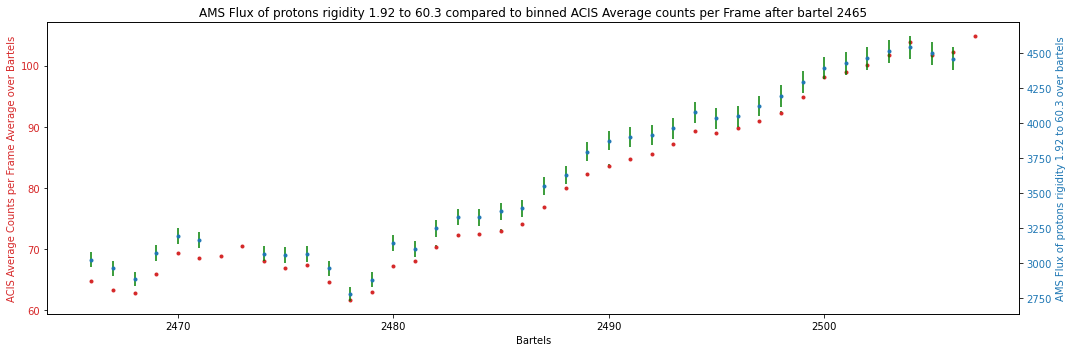

In [408]:
#plotting bartels after rotation 2470 for both ACIS and AMS together
barts_acis, aacpf, rmss = acis_binning(l_bound, u_bound)

abarts, afluxes = dat_split_after(cutoff, barts, fluxes)
abarts, afluxerr = dat_split_after(cutoff, barts, allthree)
abarts_acis, aaacpf = dat_split_after(cutoff, barts_acis, aacpf)
abarts_acis, armss = dat_split_after(cutoff, barts_acis, rmss)

t1 = abarts_acis
t2 = abarts
data1 = aaacpf
data2 = afluxes 
data1err = armss
data2err = afluxerr

fig, ax1 = plt.subplots(figsize=(15, 5))

color = 'tab:red'
ax1.set_xlabel('Bartels')
ax1.set_ylabel('ACIS Average Counts per Frame Average over Bartels', color=color)
ax1.errorbar(t1, data1, color=color, yerr=[data1err, data1err], fmt='.', ecolor='g', capthick=8)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(f'AMS Flux of {part}s rigidity {r1} to {r2} over bartels', color=color)
ax2.errorbar(t2, data2, color=color, yerr=[data2err, data2err], fmt='.', ecolor='g', capthick=8)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim(4500,9000)

plt.title(f"AMS Flux of {part}s rigidity {r1} to {r2} compared to binned ACIS Average counts per Frame after bartel {cutoff}")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Choose for the floowing plots the cutoff bartel and what section to look at.

2465 is approximately the solar maximum which is around april 2014.

In [409]:
#cut is the cutoff bartel at which where to split the data
#2465 is approximately the solar maximum which is around april 2014
cut = 2465


Choose between 'before' cut, 'after' cut, or 'without' cut.

In [410]:
#Choose between 'before' cut, 'after' cut, or 'without' cut
state = 'after'

In [411]:
#Get acis data to work 
barts_acis, aacpf, rmss= acis_binning(l_bound, u_bound)

#match data points by deleting data for the missing data on AMS bartel rotations 2507, 2472, and 2473
dat = np.array(aacpf, dtype=np.float64)
daterr = np.array(rmss, dtype=np.float64)
#print(aacpf, len(aacpf))
#print(aacpf[81])

dat = np.delete(dat, 81) #(2507)
dat = np.delete(dat, 47) #(2472)
dat = np.delete(dat, 46) #(2473)

daterr = np.delete(daterr, 81) #(2507)
daterr = np.delete(daterr, 47) #(2472)
daterr = np.delete(daterr, 46) #(2473)
print(len(aacpf), len(dat), len(barts), len(daterr))

2011.3698630136987 2017.282191780822
82 79 79 79


slope: 0.043811    intercept: 45.507795
R-squared: 0.991295     RMS: 0.202174    dRMS: 300080.758362


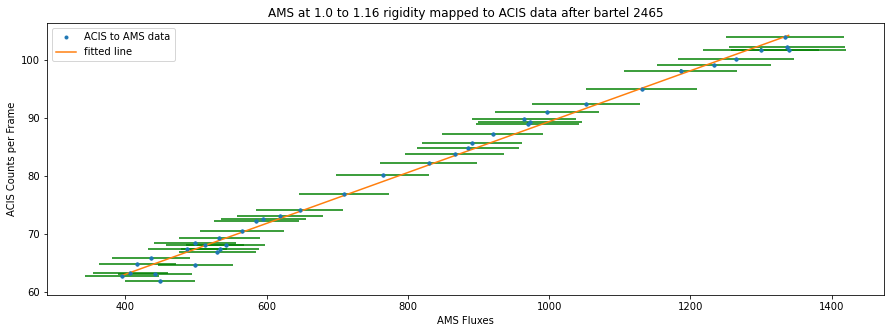

In [413]:
#Checking how closely correlated AMS and ACIS data are for a single AMS rigidity
#This plot shows exactly what is being calculated in the following plots for each data point

r1, r2, fluxes, fluxerr = create_pflux_data(0, 0)

abarts, afluxes = dat_split_after(cut, barts, fluxes)
abarts, adat = dat_split_after(cut, barts, dat)
abarts, afluxerr = dat_split_after(cut, barts, allthree)
abarts, adaterr = dat_split_after(cut, barts, daterr)

bbarts, bfluxes = dat_split_before(cut, barts, fluxes)
bbarts, bdat = dat_split_before(cut, barts, dat)
bbarts, bfluxerr = dat_split_before(cut, barts, allthree)
bbarts, bdaterr = dat_split_before(cut, barts, daterr)

#the next plot either plots all data, before the cotoff, or after the cutoff

if state=='without':
    sfluxes, sdat, sfluxerr, sdaterr= reorder(fluxes, dat, fluxerr, daterr)
elif state=='after':  
    sfluxes, sdat, sfluxerr, sdaterr= reorder(afluxes, adat, afluxerr, adaterr)
elif state=='before':  
    sfluxes, sdat, sfluxerr, sdaterr= reorder(bfluxes, bdat, bfluxerr, bdaterr)

slope, intercept, r_value, p_value, std_err = stats.linregress(sfluxes, sdat)

#Absolute RMS
RMS, dRMS = get_RMS(sfluxes, sdat, sfluxerr, sdaterr, slope, intercept)

print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f     RMS: %f    dRMS: %f" % (r_value**2, RMS, dRMS))

plt.figure(figsize = (15,5))
plt.plot(sfluxes, sdat, '.', label=f'ACIS to AMS data')
plt.errorbar(sfluxes, sdat, yerr=[sdaterr, sdaterr], xerr=[sfluxerr, sfluxerr], fmt='.', ecolor='g', capthick=8)
plt.plot(sfluxes, intercept + slope*sfluxes, label='fitted line')
#plt.plot(sfluxes, intercept + slope*sfluxes + RMS, label='fitted line + 1 standard deviation', color= 'yellow')
#plt.plot(sfluxes, intercept + slope*sfluxes - RMS, label='fitted line - 1 standard deviation', color= 'yellow')
plt.legend()

plt.title(f"AMS at {r1} to {r2} rigidity mapped to ACIS data {state} bartel {cut}")
plt.xlabel(f"AMS Fluxes")
plt.ylabel(f"ACIS Counts per Frame")
plt.show()
#This means that the data points are in no particular order and that the more linear looking the scatter plot is
#the more likely the ACIS and AMS are detecting the same particles at that energy range

In [418]:
#plotting Rsquared over the smaller rigidity bins (0-44)
#Split at greater than cutoff
Rsq = []
RMSs = []
dRMSs = []
fRMSs = []
fdRMSs = []
slopes = []
intercepts = []
x_values = []
portion_of_whole = []
#total flux over the entire ams active duration


#set the string in the window variable as 'without' or 'before' or 'after' cut 
#to change what portion of the data you wish to look at
#modify this variable to change what you see in the next two plots

window = 'after'
    
#creates the Rsquare values accross all rigidity bins
#45 for rigidity range
#Based on the window, the data reduced to before or after or not at all
for i in range(45):
    r1, r2, fluxes, fluxerr = create_pflux_data(i, i)
    if window=='without':
        sfluxes, sdat, sfluxerr, sdaterr= reorder(fluxes, dat, fluxerr, daterr)
        portion_of_whole.append(100*sum(fluxes)/sum(p))
    
    elif window=='after':
        abarts, afluxes = dat_split_after(cut, barts, fluxes)
        abarts, adat = dat_split_after(cut, barts, dat)
        #uncertanties
        abarts, afluxerr = dat_split_after(cut, barts, allthree)
        abarts, adaterr = dat_split_after(cut, barts, daterr)
        
        ab, ap = dat_split_after(cut, bartels, p)
        sfluxes, sdat, sfluxerr, sdaterr= reorder(afluxes, adat, afluxerr, adaterr)
        portion_of_whole.append(100*sum(afluxes)/sum(ap))
        
    elif window=='before':
        bbarts, bfluxes = dat_split_before(cut, barts, fluxes)
        bbarts_acis, bdat = dat_split_before(cut, barts, dat)
        #uncertanties
        bbarts, bfluxerr = dat_split_before(cut, barts, allthree)
        bbarts_acis, bdaterr = dat_split_before(cut, barts, daterr)
        
        bb, bp = dat_split_before(cut, bartels, p)
        sfluxes, sdat, sfluxerr, sdaterr= reorder(bfluxes, bdat, bfluxerr, bdaterr)
        portion_of_whole.append(100*sum(bfluxes)/sum(bp))      
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(sfluxes, sdat)
    Rsq.append(r_value**2)
    r, dr = (get_RMS(sfluxes, sdat, sfluxerr, sdaterr, slope, intercept))
    fr, fdr = (get_fRMS(sfluxes, sdat, sfluxerr, sdaterr, slope, intercept))
    RMSs.append(r)
    dRMSs.append(dr)
    fRMSs.append(fr)
    fdRMSs.append(fdr)
    slopes.append(slope)
    intercepts.append(slope)
    x_values.append(r1/2 + r2/2)

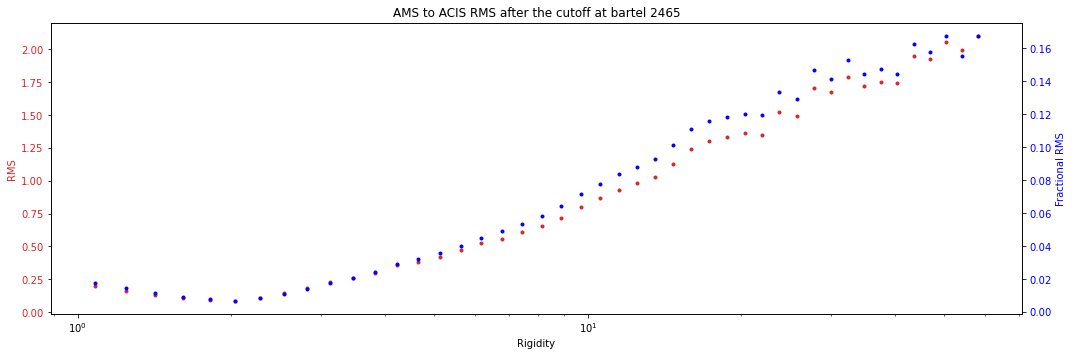

In [419]:
#Plots The scatter of RMS values for all rigidity bins based on cutoff or not
t1 = x_values
t2 = x_values
data1 = RMSs
data2 = fRMSs

fig, ax1 = plt.subplots(figsize=(15, 5))

color = 'tab:red'
ax1.set_xlabel('Rigidity')
ax1.set_ylabel('RMS', color=color)
ax1.plot(t1 , data1, '.', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'blue'
ax2.set_ylabel(f'Fractional RMS', color=color)  # we already handled the x-label with ax1
ax2.plot(t2, data2,  '.', color=color)
ax2.tick_params(axis='y', labelcolor=color)

#ax1.set_ylim(-0.1,1.1)
plt.title(f"AMS to ACIS RMS {window} the cutoff at bartel {cut}")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xscale('log')
plt.show()

#It looks like AMS can predict ACIS well at around the 2GV rigidity bin the best. That means it is possible that the majority 
#of particles causing rejected background events on ACIS are probably particles of that energy range. 
#

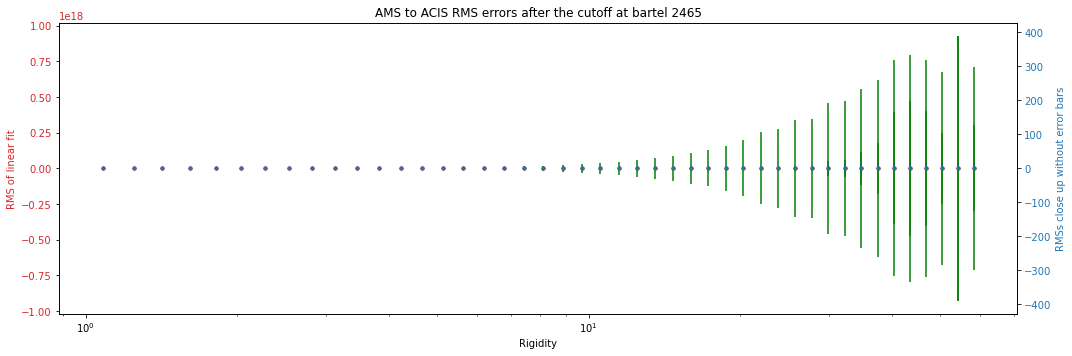

In [420]:
#Some bad plots to track what RMSs is doing
t1 = x_values
t2 = x_values
data1 = RMSs
data2 = fRMSs
data1err = dRMSs
data2err = fdRMSs
fig, ax1 = plt.subplots(figsize=(15, 5))

color = 'tab:red'
ax1.set_xlabel('Rigidity')
ax1.set_ylabel('RMS of linear fit', color=color)
ax1.errorbar(t1, data1, color = color, yerr=[data1err, data1err], fmt='.', ecolor='g', capthick=8)
ax1.plot(t1, data1, '.', color = color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel(f'RMSs close up without error bars', color=color)  # we already handled the x-label with ax1
ax2.errorbar(t2, data2, color = color, yerr=[data2err, data2err], fmt='.', ecolor='g', capthick=8)
#ax2.plot(t2, data2,  '.', color=color)
#ax2.plot(t2, data2err,  '.', color='orange')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"AMS to ACIS RMS errors {window} the cutoff at bartel {cut}")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xscale('log')
plt.show()

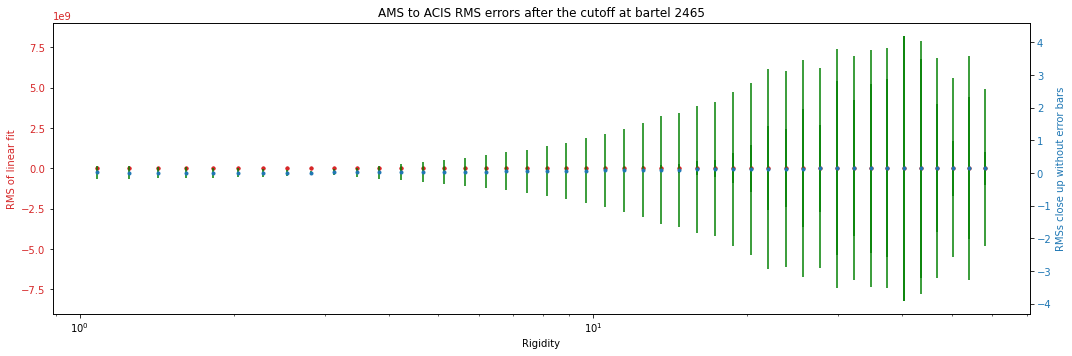

In [238]:
t1 = x_values
t2 = x_values
data1 = RMSs
data2 = fRMSs
data1err = dRMSs
data2err = fdRMSs
fig, ax1 = plt.subplots(figsize=(15, 5))

color = 'tab:red'
ax1.set_xlabel('Rigidity')
ax1.set_ylabel('RMS of linear fit', color=color)
ax1.errorbar(t1, data1, color = color, yerr=[data1err, data1err], fmt='.', ecolor='g', capthick=8)
ax1.plot(t1, data1, '.', color = color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel(f'RMSs close up without error bars', color=color)  # we already handled the x-label with ax1
ax2.errorbar(t2, data2, color = color, yerr=[data2err, data2err], fmt='.', ecolor='g', capthick=8)
#ax2.plot(t2, data2,  '.', color=color)
#ax2.plot(t2, data2err,  '.', color='orange')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"AMS to ACIS RMS errors {window} the cutoff at bartel {cut}")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xscale('log')
plt.show()


In [153]:
#quick check of the conversion of rigidity to energy
rigidity = 2.0
print(rigidity_to_energy(rigidity, r = None, particle='proton'))

1.2320421556341048


slope: 0.015143    intercept: 8.742868
R-squared: 0.857435     RMS: 2.096021


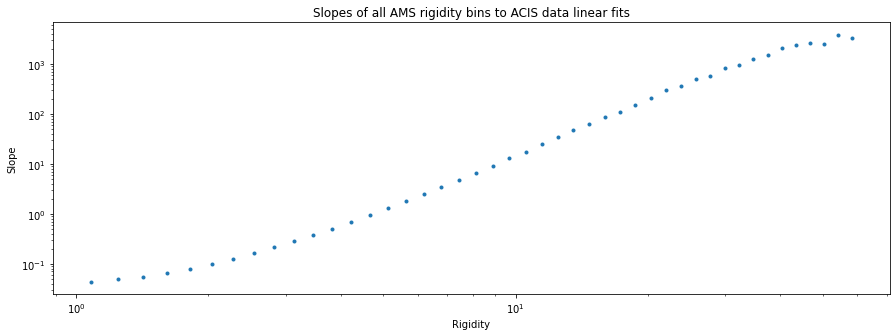

In [38]:
slope, intercept, r_value, p_value, std_err = stats.linregress(slopes, x_values)

RMS = get_fRMS(slopes, x_values, slope, intercept)

print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f     RMS: %f" % (r_value**2, RMS))

plt.figure(figsize = (15,5))
plt.plot(x_values, slopes, '.', label=f'ACIS to AMS data')
#plt.plot(x_values, intercept + slope*x_values, label='fitted line')
#plt.plot(x_values, intercept + slope*x_values + RMS, label='fitted line + 1 standard deviation', color= 'green')
#plt.plot(x_values, intercept + slope*x_values - RMS, label='fitted line - 1 standard deviation', color= 'green')
#plt.legend()

plt.title(f"Slopes of all AMS rigidity bins to ACIS data linear fits")
plt.xlabel(f"Rigidity")
plt.ylabel(f"Slope")
plt.xscale('log')
plt.yscale('log')
plt.show()

slope: 0.015143    intercept: 8.742868
R-squared: 0.857435     RMS: 2.096021


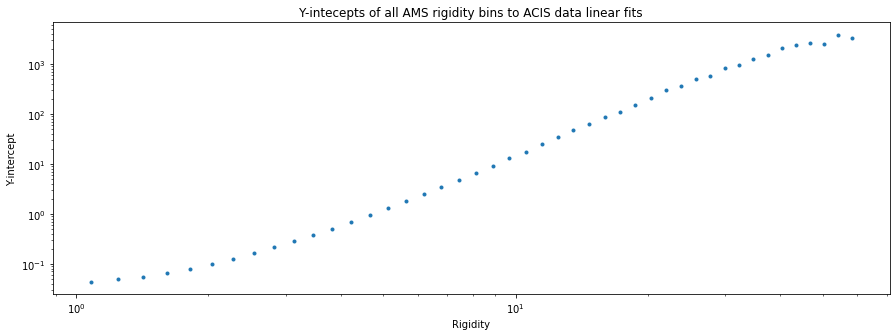

In [39]:
slope, intercept, r_value, p_value, std_err = stats.linregress(slopes, x_values)

RMS = get_fRMS(intercepts, x_values, slope, intercept)

print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f     RMS: %f" % (r_value**2, RMS))

plt.figure(figsize = (15,5))
plt.plot(x_values, slopes, '.', label=f'ACIS to AMS data')
#plt.plot(x_values, intercept + slope*x_values, label='fitted line')
#plt.plot(x_values, intercept + slope*x_values + RMS, label='fitted line + 1 standard deviation', color= 'green')
#plt.plot(x_values, intercept + slope*x_values - RMS, label='fitted line - 1 standard deviation', color= 'green')
#plt.legend()

plt.title(f"Y-intecepts of all AMS rigidity bins to ACIS data linear fits")
plt.xlabel(f"Rigidity")
plt.ylabel(f"Y-intercept")
plt.xscale('log')
plt.yscale('log')
plt.show()

# Back to Brian's plots

In [40]:
csv_x = x_from_dates(bartels, bartels_to_date)

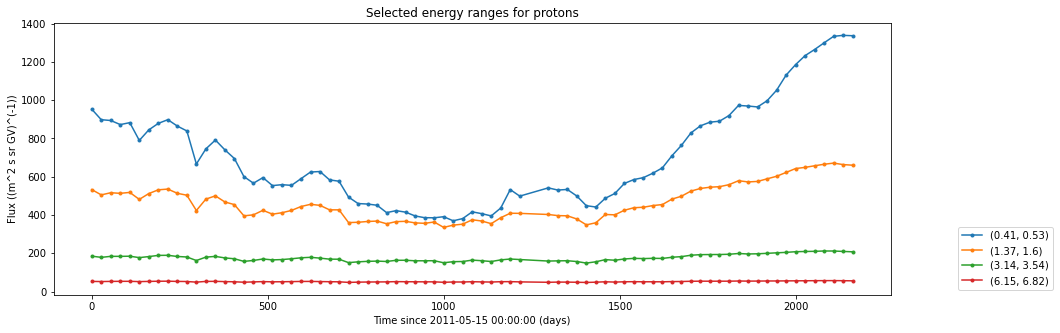

In [41]:
rigid_indx = {}
k = 0

for rig in zip(R1, R2):
    rigid_indx[rig] = rigid_indx.get(rig, []) + [k]
    k += 1
ranges = list(rigid_indx.keys())

plt.figure(figsize = (15,5))

rrs = []
pls = []

#loops through the different ranges to produce new curves for each one
#unsure of how the ranges[:20:6]: functions or how the numbers are determined
for rr in ranges[:20:6]:
    rrs.append(rr)
    indxs = rigid_indx[rr]
    p1 = p[indxs]
    #plots a new curve
    new_x = csv_x[indxs]
    pl = plt.plot(new_x, p1, '.-')
    pls.append(pl)

ncol = len(rrs) // 20 + 1
sep = 1.2 + .2 * (ncol - 1)
ers = [(rigidity_to_energy(float(rr[0]), 2), rigidity_to_energy(float(rr[1]), 2)) for rr in rrs]
plt.legend(ers, bbox_to_anchor=(0, 0, sep, 0), loc = 'lower right', ncol = ncol)

plt.title(f"Selected energy ranges for protons")
plt.xlabel(f"Time since {bartels_to_date(bartels[0])} (days)")
plt.ylabel(f"Flux ({header.find('UNITS/flux').text})")
plt.show()
None

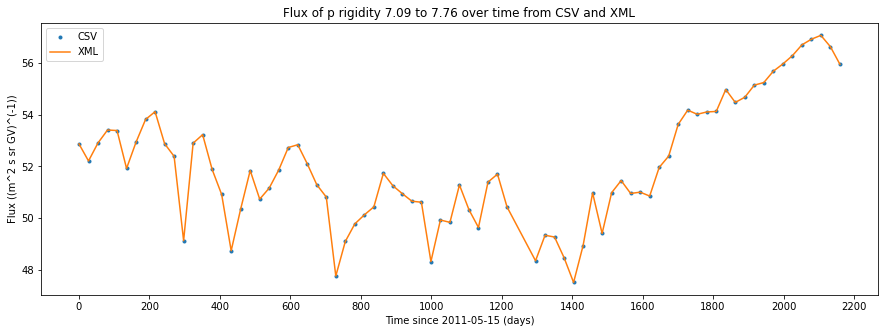

In [42]:
xml_file = p_files[-4] #xml file path

root = ET.parse(xml_file).getroot() #parses the xml and returns the root element
all_data = root.findall('DATA') #all of the data
mins = [data.find("time_min").text for data in all_data] #all of the start times of measurements
x = x_from_dates(mins, dt)
fluxes = [float(data.find("flux").text) for data in all_data] #fluxes for each of the measurements
min_rigid = root.find('DATA/rigidity_min').text
max_rigid = root.find('DATA/rigidity_max').text

plt.figure(figsize = (15,5))
#plt.errorbar(x, fluxes, yerr=[np.array(errors_low), np.array(errors_low)], fmt='o-', ecolor='g', capthick=8)

plt.plot(x, fluxes, '.')
indxs = rigid_indx[float(min_rigid), float(max_rigid)]

plt.plot(csv_x[indxs], p[indxs], '-')

plt.title(f"Flux of {particle} rigidity {min_rigid} to {max_rigid} over time from CSV and XML")
plt.xlabel(f"Time since {mins[0].split('T')[0]} (days)")
plt.xticks(range(0,x[-1]+ 100, 200))

plt.ylabel(f"Flux ({header.find('UNITS/flux').text})")
plt.legend(['CSV', 'XML'])
plt.show()

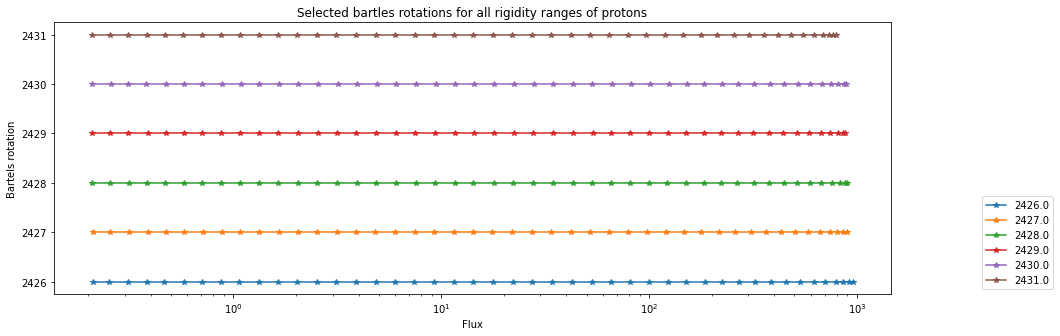

In [43]:
date_indx = {}
k = 0
for rig in bartels:
    date_indx[rig] = date_indx.get(rig, []) + [k]
    k += 1
ranges = list(date_indx.keys())

plt.figure(figsize = (15,5))
dates = []
for date in ranges[0:6]:
    dates.append(date)
    indxs = date_indx[date]
    p1 = p[indxs]
    new_x = bartels[indxs] #csv_x[indxs]
    pl = plt.plot(p1, new_x, '*-')
    
ncol = len(dates) // 20 + 1
sep = 1.2 + .2 * (ncol - 1)
plt.legend(dates, bbox_to_anchor=(0, 0, sep, 0), loc = 'lower right', ncol = ncol)
plt.title(f"Selected bartles rotations for all rigidity ranges of protons")
plt.ylabel(f"Bartels rotation")
plt.xlabel(f"Flux")
plt.xscale("log")
plt.yticks(dates)
None

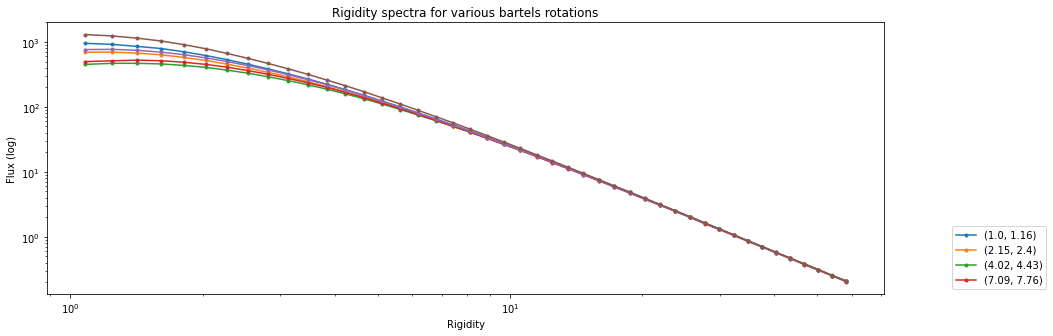

In [44]:
date_indx = {}
k = 0
for rig in bartels:
    date_indx[rig] = date_indx.get(rig, []) + [k]
    k += 1
bartels_rotations = list(date_indx.keys())

plt.figure(figsize = (15,5))
brs = []
for br in bartels_rotations[0:-1:15]:
    brs.append(str(br))
    indxs = date_indx[br]
    p1 = p[indxs]
    r = (R1[indxs] + R2[indxs]) / 2
    plt.plot(r, p1, '.-')

scale = "log"
    
ncol = len(rrs) // 20 + 1
sep = 1.2 + .2 * (ncol - 1)
plt.legend(rrs, bbox_to_anchor=(0, 0, sep, 0), loc = 'lower right', ncol = ncol)
plt.title(f"Rigidity spectra for various bartels rotations")
plt.xlabel(f"Rigidity")
plt.yscale(scale)
plt.xscale(scale)
plt.ylabel(f"Flux ({scale})")

None

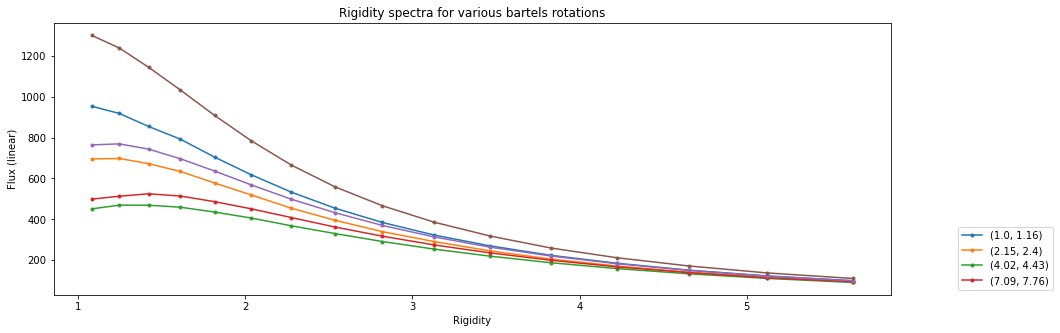

In [45]:
min_rigidity = 0
max_rigidity = 6
date_indx = {}
k = 0
for rig in bartels:
    if min_rigidity< R2[k] < max_rigidity:
        date_indx[rig] = date_indx.get(rig, []) + [k]
    k += 1
bartels_rotations = list(date_indx.keys())

plt.figure(figsize = (15,5))
brs = []
for br in bartels_rotations[0:-1:15]:
    brs.append(str(br))
    indxs = date_indx[br]
    p1 = p[indxs]
    r = (R1[indxs] + R2[indxs]) / 2
    plt.plot(r, p1, '.-')

scale = "linear"
    
ncol = len(rrs) // 20 + 1
sep = 1.2 + .2 * (ncol - 1)
plt.legend(rrs, bbox_to_anchor=(0, 0, sep, 0), loc = 'lower right', ncol = ncol)
plt.title(f"Rigidity spectra for various bartels rotations")
plt.xlabel(f"Rigidity")
plt.yscale(scale)
plt.ylabel(f"Flux ({scale})")

None

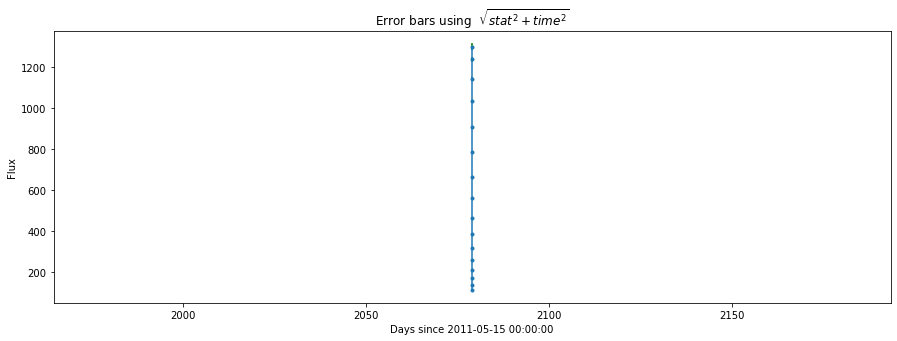

In [46]:
plt.figure(figsize = (15,5))
errors = np.sqrt(np.square(p_stat) + np.square(p_time))
plt.errorbar(csv_x[indxs], p[indxs], yerr=errors[indxs], fmt='.-', ecolor='g')
plt.title(r"Error bars using  $\sqrt{stat^2 + time^2} $")
plt.xlabel(f"Days since {bartels_to_date(bartels[0])}")
plt.ylabel(f"Flux")
None

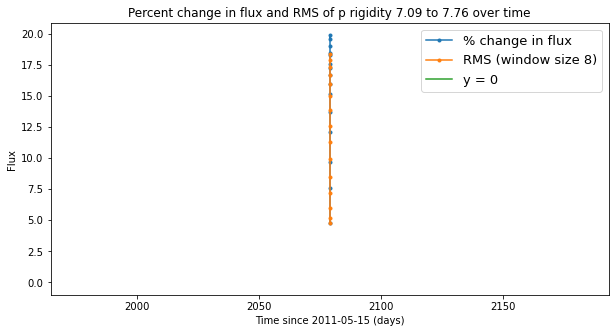

In [47]:
window_size = 8

plt.figure(figsize = (10,5))
new_x = csv_x[indxs][:-1]
delta_flux = [100*(p[indxs][i] - p[indxs][i+1])/p[indxs][i] for i in range(len(p[indxs]) -1)]
errors = []
#plt.errorbar(new_x, delta_flux, yerr=None, fmt='o-', ecolor='g', capthick=8)
pl = plt.plot(new_x, delta_flux, '.-', new_x, run_avg(delta_flux, window_size, 0), '.-', new_x, [0]*len(new_x))
plt.legend(pl, ['% change in flux', f'RMS (window size {window_size})', 'y = 0'], prop={'size': 13})
plt.title(f"Percent change in flux and RMS of p rigidity {min_rigid} to {max_rigid} over time")
plt.xlabel(f"Time since {mins[0].split('T')[0]} (days)")
#plt.xticks(range(0,new_x[-1]+ 100, 200))
plt.ylabel(f"Flux")

plt.show()

In [48]:
def ranges_from_points(p):
    for i in range(len(p) - 1):
        yield (p[i], p[i + 1])

def get_using(low, high):
    using = []
    for i in ranges:
        if i[0] > low and i[0] < high:
            using.append(i)
            a = rigid_indx[i]
    return using

def get_cum_flux(using, weighted = True):
    def cum_sum(rr, using, i, weighted):
        w = (rr[1] - rr[0]) if weighted else 1    
        return np.array([w * p[rigid_indx[rr]][i] for rr in using]).sum()
    return [cum_sum(rr, using, i, weighted) for i in range(len(rigid_indx[using[0]]))]

plt.figure(figsize = (15,5))
points = [22.5, 25, 33, 80]
rrs = [] 
for l, h in ranges_from_points(points):
    using = get_using(l, h)
    cum_flux = get_cum_flux(using)
    plt.plot(csv_x[rigid_indx[using[0]]], cum_flux, '.-')
    rrs.append((using[0][0], using[-1][1]))

title = f"rigidity {using[0][0]} to {using[-1][1]}" if len(points) == 2 else "various rigidity ranges"
plt.title(f"Cumulative weighted flux for {title}")
plt.xlabel(f"Time since {mins[0].split('T')[0]} (days)")
plt.ylabel(f"Flux")
if len(points) != 2:
    plt.legend(rrs)

None

IndexError: invalid index to scalar variable.

<Figure size 1080x360 with 0 Axes>

In [ ]:
a = np.genfromtxt('ctifinaltable.txt', skip_header = 2)
    
a.T[0]

In [ ]:
plt.subplot(223)
plt.plot([1, 2, 3], label="test1")
plt.plot([3, 2, 1], label="test2")
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1, .5, 1), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.)

plt.show()

In [ ]:
line_up, = plt.plot([1, 2, 3], label='Line 2')
line_down, = plt.plot([3, 2, 1], label='Line 1')
plt.legend(handles=[line_up, line_down])

In [ ]:
xml_filea = he_files[0]
xml_fileb = he_files[1]

roota = ET.parse(xml_filea).getroot()
rootb = ET.parse(xml_fileb).getroot()

all_a = roota.findall('DATA') #all of the data
all_b = rootb.findall('DATA') #all of the data

minsa = [data.find("time_min").text for data in all_a] #all of the start times of measurements
minsb = [data.find("time_min").text for data in all_b] #all of the start times of measurements

minsa[-1], minsb[0]

In [ ]:
mins = []
maxs = []
for file in he_files:
    root = ET.parse(file).getroot()
    mins.append(root.find('DATA/rigidity_min').text)
    maxs.append(root.find('DATA/rigidity_max').text)
[(i,j) for i,j in zip(mins,maxs)]

In [ ]:
def time_intervals(data):
    def dt(time):
        return datetime.datetime.strptime(time, '%Y-%m-%dT%H:%M:%S')
    cumsum, vals = 0, []
    for i in range(len(data) -1):
        delta = dt(data[i+1].find("time_min").text) - dt(data[i].find("time_min").text)
        days = delta.days
        vals.append(cumsum)
        cumsum += days
    vals.append(cumsum)
    return vals

intervals = time_intervals(all_data)

In [ ]:
import datetime



def time_dif(first, second):
    def dt(time):
        return datetime.datetime.strptime(time, '%Y-%m-%dT%H:%M:%S')
    return (dt(second.find("time_min").text) - dt(first.find("time_min").text)).days

[time_dif(all_data[i], all_data[i+1])  for i in range(len(all_data) -1)]
None

In [ ]:
def xml_dict(root):
    children = root.findall('*')
    if not children:
        return {root.tag: root.text}
    return {root.tag: [xml_dict(child) for child in children]}

def xml_dict2(root):
    children = root.findall('*')
    if not children:
        return root.text
    return {root.tag: {child.tag : xml_dict(child) for child in children}}

dic = xml_dict(root)
dic

# Graphs for poster

In [ ]:
plt.figure(figsize = (10,5))
errors = np.sqrt(np.square(p_stat) + np.square(p_time))
plt.errorbar(csv_x[indxs], p[indxs], yerr=errors[indxs], fmt='.-', ecolor='g')
plt.title(r"Error bars using  $\sqrt{stat^2 + time^2} $")
plt.xlabel(f"Days since {bartels_to_date(bartels[0])}")
plt.ylabel(f"Flux")
None

In [ ]:
#number of curves
#ticks
#legend
#errorbars

errors = np.sqrt(np.square(p_stat) + np.square(p_time))
rigid_indx = {}
k = 0
for rig in zip(R1, R2):
    rigid_indx[rig] = rigid_indx.get(rig, []) + [k]
    k += 1
ranges = list(rigid_indx.keys())

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = list(prop_cycle.by_key()['color'])

In [ ]:
plt.figure(figsize = (10,5))
rrs = []
i = 0
for rr in [ranges[i] for i in [0,6,14,30]]:#ranges[:20:6]:
    rrs.append(rr)
    indxs = rigid_indx[rr]
    p1 = p[indxs]
    new_x = csv_x[indxs]
    #pl = plt.plot(new_x, p1, '.-')
    plt.errorbar(csv_x[indxs], p[indxs], yerr=errors[indxs], fmt= '.-', ecolor=colors[i], color = colors[i])
    i += 1

ncol = len(rrs) // 20 + 1
sep = 1.2 + .2 * (ncol - 1)
ers = [f"{rigidity_to_energy(float(rr[0]), 2)} - {rigidity_to_energy(float(rr[1]), 2)} GeV" for rr in rrs]
plt.annotate(ers[0], (0,1000))
plt.annotate(ers[1], (0,570))
plt.annotate(ers[2], (0,200))
plt.annotate(ers[3], (0,35))
#plt.legend(ers)#, bbox_to_anchor=(0, 0, sep, 0), loc = 'lower right', ncol = ncol)
plt.title(f"Selected energy ranges for protons")
plt.xlabel(f"Time since {str(bartels_to_date(bartels[0]))[:-9]} (days)")
plt.ylabel(f"Flux ({header.find('UNITS/flux').text})")
#plt.xticks(*make_ticks(0, new_x[-1]+ 100, 27, 8))
None

In [ ]:
window_size = 8
plt.figure(figsize = (10,5))
rr = ranges[0]
indxs = rigid_indx[rr]
new_x = csv_x[indxs][:-1]
delta_flux = []
delta_errors = []
for i in range(len(p[indxs]) -1):
    sv = 100*(p[indxs][i] - p[indxs][i+1])
    dv = p[indxs][i]
    delta_flux.append(sv / dv)
    
    de = ((errors[indxs][i] / p[indxs][i]) ** 2 + (errors[indxs][i + 1] / p[indxs][i + 1]) ** 2) ** .5
    delta_errors.append(100 * de)

pl1 = plt.errorbar(new_x, delta_flux, yerr=delta_errors, fmt='.-', ecolor='g', capthick=8)
pl2 = plt.errorbar(new_x, run_avg(delta_flux, window_size, 0), yerr=None, fmt='.-', ecolor='g', capthick=8, color = colors[1])
plt.plot(new_x, [0]*len(new_x), color = colors[3])
#pl = plt.plot(new_x, delta_flux, '.-', new_x, run_avg(delta_flux, window_size, 0), '.-', new_x, [0]*len(new_x))

plt.legend([pl1, pl2], ['% change in flux', f'RMS (window size {window_size})'], prop={'size': 13})
plt.title(f"Percent change in flux and RMS of protons energy {rigidity_to_energy(float(rr[0]), 2)} to {rigidity_to_energy(float(rr[1]), 2)} over time")
plt.xlabel(f"Time since {str(bartels_to_date(bartels[0]))[:-9]} (days)")
#plt.xticks(range(0,new_x[-1]+ 100, 200))
plt.ylabel(f"% change in flux")

plt.show()
#error bars shown, but not visible

In [ ]:
min_rigidity = 0
max_rigidity = 6
date_indx = {}
k = 0
for rig in bartels:
    if min_rigidity < R2[k] < max_rigidity:
        date_indx[rig] = date_indx.get(rig, []) + [k]
    k += 1
bartels_rotations = list(date_indx.keys())

plt.figure(figsize = (10,5))
brs = []
for br in bartels_rotations[::15]:
    brs.append(str(bartels_to_date(br))[:-9])
    indxs = date_indx[br]
    p1 = p[indxs]
    r = [rigidity_to_energy(x) for x in (R1[indxs] + R2[indxs]) / 2]
    plt.plot(r, p1, '.-')

scale = "linear"
    
ncol = len(rrs) // 20 + 1
sep = 1.2 + .2 * (ncol - 1)
plt.legend(brs)#, bbox_to_anchor=(0, 0, sep, 0), loc = 'lower right', ncol = ncol)
plt.title(f"Energy spectra for various dates")
plt.xlabel(f"Energy (GeV)")
plt.yscale(scale)
plt.ylabel(f"Flux ({header.find('UNITS/flux').text})")

plt.yticks(range(0, 1300, 200))
#y axis go to zero
None